# Clustering of Cancer cells

## Import

In [129]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import scanpy as sc
import scarches as sca

In [130]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_b128_lay4_h1024_raydefault_epocs300-300/'
surgeries = '/root/datos/maestria/netopaas/luca_explore/surgeries/'
atlas_dir = '/root/datos/maestria/netopaas/luca/data/atlas/'
# The atlas with only tumor primary tissues and uicc stage annotated
id_ = 'extended_tumor_hvg'

In [131]:
ref_latent_base = sc.read(f'{ref_path}/ref_latent.h5ad')

In [132]:
ref_latent = ref_latent_base.copy()
ref_latent.obs = ref_latent.obs[['cell_type', 'batch']]
ref_latent

AnnData object with n_obs × n_vars = 402634 × 10
    obs: 'cell_type', 'batch'

In [133]:
ref_latent.obs

cell_type            batch
0       T cell CD8 effector memory  Chen_Zhang_2020
1                 Tumor cells LUAD  Chen_Zhang_2020
2                           B cell  Chen_Zhang_2020
3                           B cell  Chen_Zhang_2020
4                      Plasma cell  Chen_Zhang_2020
...                            ...              ...
402629                 Neutrophils         UKIM-V-2
402630                 Neutrophils         UKIM-V-2
402631                 Neutrophils         UKIM-V-2
402632                 Neutrophils         UKIM-V-2
402633                 Neutrophils         UKIM-V-2

[402634 rows x 2 columns]

In [134]:
import h5py
from anndata.experimental import read_elem

with h5py.File(f'{atlas_dir}/{id_}.h5ad', 'r') as f:
  # Check if 'obs' group exists (common for scRNA-seq data)
  if 'obs' in f:
    obs_matrix = read_elem(f['obs'])
  else:
    # Handle the case where 'obs' is not present
    print("obs matrix not found in the h5ad file.")

obs_matrix['uicc_stage'].unique()

['III', 'I', 'IV', 'II', 'III or IV']
Categories (5, object): ['I', 'II', 'III', 'III or IV', 'IV']

In [135]:
ref_latent.obs.index = obs_matrix.index
ref_latent.obs['stage'] = obs_matrix['uicc_stage']
ref_latent.obs

cell_type            batch stage
AAACCCAAGAGCCATG-1_0-1  T cell CD8 effector memory  Chen_Zhang_2020   III
AAACCCAAGATTAGAC-1_0-1            Tumor cells LUAD  Chen_Zhang_2020   III
AAACCCAAGGTCGCCT-1_0-1                      B cell  Chen_Zhang_2020   III
AAACCCAAGTCATTGC-1_0-1                      B cell  Chen_Zhang_2020   III
AAACCCACACGGATCC-1_0-1                 Plasma cell  Chen_Zhang_2020   III
...                                            ...              ...   ...
811511_27-3                            Neutrophils         UKIM-V-2     I
468397_27-3                            Neutrophils         UKIM-V-2     I
115884_27-3                            Neutrophils         UKIM-V-2     I
201201_27-3                            Neutrophils         UKIM-V-2     I
194204_27-3                            Neutrophils         UKIM-V-2     I

[402634 rows x 3 columns]

In [136]:
ref_latent.obs['stage'].unique()

['III', 'I', 'IV', 'II', 'III or IV']
Categories (5, object): ['I', 'II', 'III', 'III or IV', 'IV']

## Concatenate

We simply concatenate the scANVI integrated datasets and the do fine clustering of the tumor cells. But may be we consider epithelial cells too

### Zuani

In [153]:
q_pred

n_genes     patient    sample environment  \
AGGCCACAGCGACGTA-1_P1_T1_Zuani      3167   Patient 1  Tumour 1      Tumour   
AGGGTGAAGTCCGTAT-1_P1_T1_Zuani      3350   Patient 1  Tumour 1      Tumour   
GTATTCTCAAGCCCAC-1_P1_T1_Zuani      3254   Patient 1  Tumour 1      Tumour   
TAGACCAAGGGCTCTC-1_P1_T1_Zuani      2376   Patient 1  Tumour 1      Tumour   
TCTCATAGTCCTGCTT-1_P1_T1_Zuani      2846   Patient 1  Tumour 1      Tumour   
...                                  ...         ...       ...         ...   
TTACGCCCAGCGACCT-1_P24_T2_Zuani     1468  Patient 24  Tumour 2      Tumour   
TTACTGTCACGGGTAA-1_P24_T2_Zuani     1381  Patient 24  Tumour 2      Tumour   
TTCCTTCCATAGGAGC-1_P24_T2_Zuani      785  Patient 24  Tumour 2      Tumour   
TTCGCTGGTCGGCTAC-1_P24_T2_Zuani     2636  Patient 24  Tumour 2      Tumour   
TTTGGTTAGCGTACAG-1_P24_T2_Zuani      866  Patient 24  Tumour 2      Tumour   

                                 n_genes_by_counts  total_counts  \
AGGCCACAGCGACGTA-1_P1_T1_Zuani                3167       16027.0   
AGGGTGAAGTCCGTAT-1_P1_T1_Zuani                3350       24043.0   
GTATTCTCAAGCCCAC-1_P1_T1_Zuani                3254       15267.0   
TAGACCAAGGGCTCTC-1_P1_T1_Zuani                2376        8181.0   
TCTCATAGTCCTGCTT-1_P1_T1_Zuani                2846       10875.0   
...                                            ...           ...   
TTACGCCCAGCGACCT-1_P24_T2_Zuani               1468        3385.0   
TTACTGTCACGGGTAA-1_P24_T2_Zuani               1381        3049.0   
TTCCTTCCATAGGAGC-1_P24_T2_Zuani                785        1511.0   
TTCGCTGGTCGGCTAC-1_P24_T2_Zuani               2636        6325.0   
TTTGGTTAGCGTACAG-1_P24_T2_Zuani                866        1843.0   

                                 total_counts_mt  pct_counts_mt  \
AGGCCACAGCGACGTA-1_P1_T1_Zuani             518.0       3.232046   
AGGGTGAAGTCCGTAT-1_P1_T1_Zuani             708.0       2.944724   
GTATTCTCAAGCCCAC-1_P1_T1_Zuani             467.0       3.058885   
TAGACCAAGGGCTCTC-1_P1_T1_Zuani             329.0       4.021513   
TCTCATAGTCCTGCTT-1_P1_T1_Zuani             182.0       1.673563   
...                                          ...            ...   
TTACGCCCAGCGACCT-1_P24_T2_Zuani            186.0       5.494830   
TTACTGTCACGGGTAA-1_P24_T2_Zuani            100.0       3.279764   
TTCCTTCCATAGGAGC-1_P24_T2_Zuani            238.0      15.751158   
TTCGCTGGTCGGCTAC-1_P24_T2_Zuani            164.0       2.592885   
TTTGGTTAGCGTACAG-1_P24_T2_Zuani            112.0       6.077048   

                                 total_counts_rb  pct_counts_rb  ...  \
AGGCCACAGCGACGTA-1_P1_T1_Zuani            4604.0      28.726524  ...   
AGGGTGAAGTCCGTAT-1_P1_T1_Zuani            5824.0      24.223267  ...   
GTATTCTCAAGCCCAC-1_P1_T1_Zuani            2657.0      17.403551  ...   
TAGACCAAGGGCTCTC-1_P1_T1_Zuani            1333.0      16.293852  ...   
TCTCATAGTCCTGCTT-1_P1_T1_Zuani            1800.0      16.551723  ...   
...                                          ...            ...  ...   
TTACGCCCAGCGACCT-1_P24_T2_Zuani            132.0       3.899557  ...   
TTACTGTCACGGGTAA-1_P24_T2_Zuani            132.0       4.329288  ...   
TTCCTTCCATAGGAGC-1_P24_T2_Zuani             62.0       4.103243  ...   
TTCGCTGGTCGGCTAC-1_P24_T2_Zuani            535.0       8.458498  ...   
TTTGGTTAGCGTACAG-1_P24_T2_Zuani             65.0       3.526858  ...   

                                                        Cell types v20  \
AGGCCACAGCGACGTA-1_P1_T1_Zuani   Cycling anti-inflammatory macrophages   
AGGGTGAAGTCCGTAT-1_P1_T1_Zuani                  Cycling plasma B cells   
GTATTCTCAAGCCCAC-1_P1_T1_Zuani                  Cycling plasma B cells   
TAGACCAAGGGCTCTC-1_P1_T1_Zuani   Cycling anti-inflammatory macrophages   
TCTCATAGTCCTGCTT-1_P1_T1_Zuani   Cycling anti-inflammatory macrophages   
...                                                                ...   
TTACGCCCAGCGACCT-1_P24_T2_Zuani                                   pDCs   
TTACTGTCACGGGTAA-

In [155]:
q_latent

AnnData object with n_obs × n_vars = 220866 × 10
    obs: 'cell_type', 'batch'

In [157]:
name = 'Zuani'
q_latent = sc.read(f'{surgeries}/Zuani/query_latent.h5ad')
q_pred = pd.read_csv(f'{surgeries}/{name}_predicted.csv', index_col=0)
q_pred.index = q_pred.index.astype(str) + f'_{name}'
q_latent.obs = q_pred.loc[:,['cell_type_tumor', 'dataset', 'stage']].rename(columns={'cell_type_tumor':'cell_type', 'dataset':'batch'})
q_latent.obs

cell_type   batch stage
index                                                                    
AAACCCAAGCAACTTC-1_P16_T2_Zuani        T cell CD8 activated  P16_T2    II
AAACCCAAGCGCTTCG-1_P16_T2_Zuani        T cell CD8 activated  P16_T2    II
AAACCCAAGGCTAACG-1_P16_T2_Zuani                  T cell CD4  P16_T2    II
AAACCCACATAGGTTC-1_P16_T2_Zuani                  T cell CD4  P16_T2    II
AAACCCACATCCTTGC-1_P16_T2_Zuani  T cell CD8 effector memory  P16_T2    II
...                                                     ...     ...   ...
TTTGATCAGTTGAATG-1_P20_T2_Zuani                 Plasma cell  P20_T2   III
TTTGATCGTCAGCTTA-1_P20_T2_Zuani          Monocyte classical  P20_T2   III
TTTGGAGGTCACCCTT-1_P20_T2_Zuani       transitional club/AT2  P20_T2   III
TTTGTTGAGTATGGAT-1_P20_T2_Zuani        Tumor cells LUAD EMT  P20_T2   III
TTTGTTGGTTGCATCA-1_P20_T2_Zuani           T cell regulatory  P20_T2   III

[220866 rows x 3 columns]

In [158]:
q_latent.obs.groupby(['stage']).size()

stage
I        3431
II     182402
III     35033
dtype: int64

In [159]:
ref_latent = ref_latent.concatenate(q_latent,batch_key=None, index_unique=None)
ref_latent.obs

/tmp/ipykernel_466716/1445844273.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ref_latent = ref_latent.concatenate(q_latent,batch_key=None, index_unique=None)


cell_type            batch  \
AAACCCAAGAGCCATG-1_0-1           T cell CD8 effector memory  Chen_Zhang_2020   
AAACCCAAGATTAGAC-1_0-1                     Tumor cells LUAD  Chen_Zhang_2020   
AAACCCAAGGTCGCCT-1_0-1                               B cell  Chen_Zhang_2020   
AAACCCAAGTCATTGC-1_0-1                               B cell  Chen_Zhang_2020   
AAACCCACACGGATCC-1_0-1                          Plasma cell  Chen_Zhang_2020   
...                                                     ...              ...   
TTTGATCAGTTGAATG-1_P20_T2_Zuani                 Plasma cell           P20_T2   
TTTGATCGTCAGCTTA-1_P20_T2_Zuani          Monocyte classical           P20_T2   
TTTGGAGGTCACCCTT-1_P20_T2_Zuani       transitional club/AT2           P20_T2   
TTTGTTGAGTATGGAT-1_P20_T2_Zuani        Tumor cells LUAD EMT           P20_T2   
TTTGTTGGTTGCATCA-1_P20_T2_Zuani           T cell regulatory           P20_T2   

                                stage  
AAACCCAAGAGCCATG-1_0-1            III  
AAACCCAAGATTAGAC-1_0-1            III  
AAACCCAAGGTCGCCT-1_0-1            III  
AAACCCAAGTCATTGC-1_0-1            III  
AAACCCACACGGATCC-1_0-1            III  
...                               ...  
TTTGATCAGTTGAATG-1_P20_T2_Zuani   III  
TTTGATCGTCAGCTTA-1_P20_T2_Zuani   III  
TTTGGAGGTCACCCTT-1_P20_T2_Zuani   III  
TTTGTTGAGTATGGAT-1_P20_T2_Zuani   III  
TTTGTTGGTTGCATCA-1_P20_T2_Zuani   III  

[623500 rows x 3 columns]

IF THE BATCH IS AT SAMPLE LEVEL WE ADD THE DATASET TO NO LOSE THAT INFO

In [160]:
name= 'Zuani'
filt = ref_latent.obs.index.str.contains(name)
ref_latent.obs.loc[filt, 'batch'] += f'_{name}'
ref_latent.obs

cell_type            batch  \
AAACCCAAGAGCCATG-1_0-1           T cell CD8 effector memory  Chen_Zhang_2020   
AAACCCAAGATTAGAC-1_0-1                     Tumor cells LUAD  Chen_Zhang_2020   
AAACCCAAGGTCGCCT-1_0-1                               B cell  Chen_Zhang_2020   
AAACCCAAGTCATTGC-1_0-1                               B cell  Chen_Zhang_2020   
AAACCCACACGGATCC-1_0-1                          Plasma cell  Chen_Zhang_2020   
...                                                     ...              ...   
TTTGATCAGTTGAATG-1_P20_T2_Zuani                 Plasma cell     P20_T2_Zuani   
TTTGATCGTCAGCTTA-1_P20_T2_Zuani          Monocyte classical     P20_T2_Zuani   
TTTGGAGGTCACCCTT-1_P20_T2_Zuani       transitional club/AT2     P20_T2_Zuani   
TTTGTTGAGTATGGAT-1_P20_T2_Zuani        Tumor cells LUAD EMT     P20_T2_Zuani   
TTTGTTGGTTGCATCA-1_P20_T2_Zuani           T cell regulatory     P20_T2_Zuani   

                                stage  
AAACCCAAGAGCCATG-1_0-1            III  
AAACCCAAGATTAGAC-1_0-1            III  
AAACCCAAGGTCGCCT-1_0-1            III  
AAACCCAAGTCATTGC-1_0-1            III  
AAACCCACACGGATCC-1_0-1            III  
...                               ...  
TTTGATCAGTTGAATG-1_P20_T2_Zuani   III  
TTTGATCGTCAGCTTA-1_P20_T2_Zuani   III  
TTTGGAGGTCACCCTT-1_P20_T2_Zuani   III  
TTTGTTGAGTATGGAT-1_P20_T2_Zuani   III  
TTTGTTGGTTGCATCA-1_P20_T2_Zuani   III  

[623500 rows x 3 columns]

### Bischoff

In [161]:
name = 'Bishoff'
q_latent = sc.read(f'{surgeries}/{name}/query_latent.h5ad')
q_pred = pd.read_csv(f'{surgeries}/{name}_predicted.csv')
q_pred.set_index(['index'], inplace=True)
q_pred.index = q_pred.index.astype(str) + f'_{name}'
q_latent.obs = q_pred.loc[:,['cell_type_tumor', 'dataset']].rename(columns={'cell_type_tumor':'cell_type', 'dataset':'batch'})
q_latent.obs['stage'] = 'III or IV'
q_latent.obs

cell_type  batch      stage
index                                                      
0_Bishoff                      T cell CD4  p033t  III or IV
1_Bishoff      T cell CD8 effector memory  p033t  III or IV
2_Bishoff         Tumor cells NSCLC mixed  p033t  III or IV
3_Bishoff      T cell CD8 effector memory  p033t  III or IV
4_Bishoff                     Plasma cell  p033t  III or IV
...                                   ...    ...        ...
11615_Bishoff            Tumor cells LUAD  p019t  III or IV
11616_Bishoff            Tumor cells LUAD  p019t  III or IV
11617_Bishoff           T cell regulatory  p019t  III or IV
11618_Bishoff  T cell CD8 effector memory  p019t  III or IV
11619_Bishoff  T cell CD8 effector memory  p019t  III or IV

[11620 rows x 3 columns]

In [162]:
print(q_latent.obs['stage'].unique())

['III or IV']


In [163]:
ref_latent = ref_latent.concatenate(q_latent,batch_key=None, index_unique=None)
ref_latent.obs

/tmp/ipykernel_466716/1445844273.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ref_latent = ref_latent.concatenate(q_latent,batch_key=None, index_unique=None)


cell_type            batch      stage
AAACCCAAGAGCCATG-1_0-1  T cell CD8 effector memory  Chen_Zhang_2020        III
AAACCCAAGATTAGAC-1_0-1            Tumor cells LUAD  Chen_Zhang_2020        III
AAACCCAAGGTCGCCT-1_0-1                      B cell  Chen_Zhang_2020        III
AAACCCAAGTCATTGC-1_0-1                      B cell  Chen_Zhang_2020        III
AAACCCACACGGATCC-1_0-1                 Plasma cell  Chen_Zhang_2020        III
...                                            ...              ...        ...
11615_Bishoff                     Tumor cells LUAD            p019t  III or IV
11616_Bishoff                     Tumor cells LUAD            p019t  III or IV
11617_Bishoff                    T cell regulatory            p019t  III or IV
11618_Bishoff           T cell CD8 effector memory            p019t  III or IV
11619_Bishoff           T cell CD8 effector memory            p019t  III or IV

[635120 rows x 3 columns]

IF THE BATCH IS AT SAMPLE LEVEL WE ADD THE DATASET TO NO LOSE THAT INFO

In [164]:
name= 'Bishoff'
filt = ref_latent.obs.index.str.contains(name)
ref_latent.obs.loc[filt, 'batch'] += f'_{name}'
ref_latent.obs

cell_type            batch      stage
AAACCCAAGAGCCATG-1_0-1  T cell CD8 effector memory  Chen_Zhang_2020        III
AAACCCAAGATTAGAC-1_0-1            Tumor cells LUAD  Chen_Zhang_2020        III
AAACCCAAGGTCGCCT-1_0-1                      B cell  Chen_Zhang_2020        III
AAACCCAAGTCATTGC-1_0-1                      B cell  Chen_Zhang_2020        III
AAACCCACACGGATCC-1_0-1                 Plasma cell  Chen_Zhang_2020        III
...                                            ...              ...        ...
11615_Bishoff                     Tumor cells LUAD    p019t_Bishoff  III or IV
11616_Bishoff                     Tumor cells LUAD    p019t_Bishoff  III or IV
11617_Bishoff                    T cell regulatory    p019t_Bishoff  III or IV
11618_Bishoff           T cell CD8 effector memory    p019t_Bishoff  III or IV
11619_Bishoff           T cell CD8 effector memory    p019t_Bishoff  III or IV

[635120 rows x 3 columns]

### Deng

In [165]:
name = 'Deng'
q_latent = sc.read(f'{surgeries}/{name}/query_latent.h5ad')
q_pred = pd.read_csv(f'{surgeries}/{name}_predicted.csv')
q_pred.set_index(['index'], inplace=True)
q_pred.index = q_pred.index.astype(str) + f'_{name}'

q_pred['stage'] = q_pred['Pathological stage']
q_pred['stage'] = q_pred['stage'].str.replace(r'^IA[1-3]$|^IB$', 'I', regex=True)
q_pred['stage'] = q_pred['stage'].str.replace('IIB', 'II')
q_pred['stage'] = q_pred['stage'].str.replace(r'^III[AB]$', 'III', regex=True)

q_latent.obs = q_pred.loc[:,['cell_type_tumor', 'dataset', 'stage']].rename(columns={'cell_type_tumor':'cell_type', 'dataset':'batch'})

q_latent.obs

cell_type batch stage
index                                              
0_Deng                        Mast cell  P001     I
1_Deng       T cell CD8 effector memory  P001     I
2_Deng                       T cell CD4  P001     I
3_Deng             T cell CD8 activated  P001     I
4_Deng                        Mast cell  P001     I
...                                 ...   ...   ...
421706_Deng                  Macrophage  P049   III
421707_Deng                 Plasma cell  P049   III
421708_Deng                      B cell  P049   III
421709_Deng  T cell CD8 effector memory  P049   III
421710_Deng                      B cell  P049   III

[421711 rows x 3 columns]

In [166]:
print(q_latent.obs['stage'].unique())

['I' 'II' 'III']


In [167]:
ref_latent = ref_latent.concatenate(q_latent,batch_key=None, index_unique=None)
ref_latent.obs

/tmp/ipykernel_466716/1445844273.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ref_latent = ref_latent.concatenate(q_latent,batch_key=None, index_unique=None)


cell_type            batch stage
AAACCCAAGAGCCATG-1_0-1  T cell CD8 effector memory  Chen_Zhang_2020   III
AAACCCAAGATTAGAC-1_0-1            Tumor cells LUAD  Chen_Zhang_2020   III
AAACCCAAGGTCGCCT-1_0-1                      B cell  Chen_Zhang_2020   III
AAACCCAAGTCATTGC-1_0-1                      B cell  Chen_Zhang_2020   III
AAACCCACACGGATCC-1_0-1                 Plasma cell  Chen_Zhang_2020   III
...                                            ...              ...   ...
421706_Deng                             Macrophage             P049   III
421707_Deng                            Plasma cell             P049   III
421708_Deng                                 B cell             P049   III
421709_Deng             T cell CD8 effector memory             P049   III
421710_Deng                                 B cell             P049   III

[1056831 rows x 3 columns]

IF THE BATCH IS AT SAMPLE LEVEL WE ADD THE DATASET TO NO LOSE THAT INFO

In [168]:
filt = ref_latent.obs.index.str.contains(name)
ref_latent.obs.loc[filt, 'batch'] += f'_{name}'
ref_latent.obs

cell_type            batch stage
AAACCCAAGAGCCATG-1_0-1  T cell CD8 effector memory  Chen_Zhang_2020   III
AAACCCAAGATTAGAC-1_0-1            Tumor cells LUAD  Chen_Zhang_2020   III
AAACCCAAGGTCGCCT-1_0-1                      B cell  Chen_Zhang_2020   III
AAACCCAAGTCATTGC-1_0-1                      B cell  Chen_Zhang_2020   III
AAACCCACACGGATCC-1_0-1                 Plasma cell  Chen_Zhang_2020   III
...                                            ...              ...   ...
421706_Deng                             Macrophage        P049_Deng   III
421707_Deng                            Plasma cell        P049_Deng   III
421708_Deng                                 B cell        P049_Deng   III
421709_Deng             T cell CD8 effector memory        P049_Deng   III
421710_Deng                                 B cell        P049_Deng   III

[1056831 rows x 3 columns]

### Hu

In [169]:
name = 'Hu'
q_latent = sc.read(f'{surgeries}/{name}/query_latent.h5ad')
q_pred = pd.read_csv(f'{surgeries}/{name}_predicted.csv')
q_pred.set_index(['index'], inplace=True)
q_pred.index = q_pred.index.astype(str) + f'_{name}'

q_pred['stage'] = q_pred['Clinical Stage']
q_pred['stage'] = q_pred['stage'].str.replace('IIIA', 'III')

q_latent.obs = q_pred.loc[:,['cell_type_tumor', 'dataset','stage']].rename(columns={'cell_type_tumor':'cell_type', 'dataset':'batch'})
q_latent.obs
print(q_latent.obs['stage'].unique())

['III']


In [170]:
ref_latent = ref_latent.concatenate(q_latent,batch_key=None, index_unique=None)
ref_latent.obs

/tmp/ipykernel_466716/1445844273.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ref_latent = ref_latent.concatenate(q_latent,batch_key=None, index_unique=None)


cell_type            batch stage
AAACCCAAGAGCCATG-1_0-1  T cell CD8 effector memory  Chen_Zhang_2020   III
AAACCCAAGATTAGAC-1_0-1            Tumor cells LUAD  Chen_Zhang_2020   III
AAACCCAAGGTCGCCT-1_0-1                      B cell  Chen_Zhang_2020   III
AAACCCAAGTCATTGC-1_0-1                      B cell  Chen_Zhang_2020   III
AAACCCACACGGATCC-1_0-1                 Plasma cell  Chen_Zhang_2020   III
...                                            ...              ...   ...
BD_immune13_111313_Hu     Tumor cells LUSC mitotic      BD_immune13   III
BD_immune13_791956_Hu                   Macrophage      BD_immune13   III
BD_immune14_462072_Hu              B cell dividing      BD_immune14   III
BD_immune14_124095_Hu              B cell dividing      BD_immune14   III
BD_immune15_20126_Hu              NK cell dividing      BD_immune15   III

[1149161 rows x 3 columns]

IF THE BATCH IS AT SAMPLE LEVEL WE ADD THE DATASET TO NO LOSE THAT INFO

In [171]:
filt = ref_latent.obs.index.str.contains(name)
ref_latent.obs.loc[filt, 'batch'] += f'_{name}'
ref_latent.obs

cell_type            batch stage
AAACCCAAGAGCCATG-1_0-1  T cell CD8 effector memory  Chen_Zhang_2020   III
AAACCCAAGATTAGAC-1_0-1            Tumor cells LUAD  Chen_Zhang_2020   III
AAACCCAAGGTCGCCT-1_0-1                      B cell  Chen_Zhang_2020   III
AAACCCAAGTCATTGC-1_0-1                      B cell  Chen_Zhang_2020   III
AAACCCACACGGATCC-1_0-1                 Plasma cell  Chen_Zhang_2020   III
...                                            ...              ...   ...
BD_immune13_111313_Hu     Tumor cells LUSC mitotic   BD_immune13_Hu   III
BD_immune13_791956_Hu                   Macrophage   BD_immune13_Hu   III
BD_immune14_462072_Hu              B cell dividing   BD_immune14_Hu   III
BD_immune14_124095_Hu              B cell dividing   BD_immune14_Hu   III
BD_immune15_20126_Hu              NK cell dividing   BD_immune15_Hu   III

[1149161 rows x 3 columns]

## Subset

In [172]:
ref_latent.obs.cell_type.unique()

array(['T cell CD8 effector memory', 'Tumor cells LUAD', 'B cell',
       'Plasma cell', 'T cell regulatory', 'Plasma cell dividing',
       'T cell CD8 dividing', 'Mast cell', 'T cell NK-like', 'T cell CD4',
       'Macrophage', 'T cell CD8 terminally exhausted',
       'Alveolar cell type 2', 'NK cell', 'Monocyte classical',
       'Neutrophils', 'T cell CD8 naive', 'cDC2', 'Macrophage alveolar',
       'Tumor cells LUAD mitotic', 'transitional club/AT2',
       'T cell CD4 dividing', 'Alveolar cell type 1', 'pDC',
       'NK cell dividing', 'Tumor cells LUSC mitotic', 'Ciliated',
       'Endothelial cell capillary', 'T cell CD8 activated',
       'B cell dividing', 'Endothelial cell venous', 'cDC1',
       'myeloid dividing', 'Club', 'Monocyte non-classical',
       'ROS1+ healthy epithelial', 'stromal dividing', 'DC mature',
       'Fibroblast alveolar', 'Fibroblast peribronchial',
       'Tumor cells LUSC', 'Smooth muscle cell', 'Pericyte',
       'Fibroblast adventitial', 'Tumor 

In [173]:
ref_latent.obs['dataset'] = ref_latent.obs['batch']

filt = ref_latent.obs.index.str.contains('Hu')
ref_latent.obs.loc[filt, 'dataset'] = 'Hu'

filt = ref_latent.obs.index.str.contains('Deng')
ref_latent.obs.loc[filt, 'dataset'] = 'Deng'

filt = ref_latent.obs.index.str.contains('Bishoff')
ref_latent.obs.loc[filt, 'dataset'] = 'Bishoff'
ref_latent.obs

filt = ref_latent.obs.index.str.contains('Zuani')
ref_latent.obs.loc[filt, 'dataset'] = 'Zuani'
ref_latent.obs

cell_type            batch stage  \
AAACCCAAGAGCCATG-1_0-1  T cell CD8 effector memory  Chen_Zhang_2020   III   
AAACCCAAGATTAGAC-1_0-1            Tumor cells LUAD  Chen_Zhang_2020   III   
AAACCCAAGGTCGCCT-1_0-1                      B cell  Chen_Zhang_2020   III   
AAACCCAAGTCATTGC-1_0-1                      B cell  Chen_Zhang_2020   III   
AAACCCACACGGATCC-1_0-1                 Plasma cell  Chen_Zhang_2020   III   
...                                            ...              ...   ...   
BD_immune13_111313_Hu     Tumor cells LUSC mitotic   BD_immune13_Hu   III   
BD_immune13_791956_Hu                   Macrophage   BD_immune13_Hu   III   
BD_immune14_462072_Hu              B cell dividing   BD_immune14_Hu   III   
BD_immune14_124095_Hu              B cell dividing   BD_immune14_Hu   III   
BD_immune15_20126_Hu              NK cell dividing   BD_immune15_Hu   III   

                                dataset  
AAACCCAAGAGCCATG-1_0-1  Chen_Zhang_2020  
AAACCCAAGATTAGAC-1_0-1  Chen_Zhang_2020  
AAACCCAAGGTCGCCT-1_0-1  Chen_Zhang_2020  
AAACCCAAGTCATTGC-1_0-1  Chen_Zhang_2020  
AAACCCACACGGATCC-1_0-1  Chen_Zhang_2020  
...                                 ...  
BD_immune13_111313_Hu                Hu  
BD_immune13_791956_Hu                Hu  
BD_immune14_462072_Hu                Hu  
BD_immune14_124095_Hu                Hu  
BD_immune15_20126_Hu                 Hu  

[1149161 rows x 4 columns]

We wanna get all the cells that could be related to the neoplastic cells. That means epithelial derived. Manually selectign from the cell types above we arrive to:

### Import

In [24]:
! mkdir $surgeries/Subcluster

In [174]:
ref_latent.write_h5ad(f'{surgeries}/Subcluster/query_latent.h5ad')

# ref_latent = sc.read(f'{surgeries}/Subcluster/query_latent.h5ad')

In [198]:
epit_types = ['Alveolar cell type 1', 'Alveolar cell type 2',  'ROS1+ healthy epithelial', 'transitional club/AT2', 'Club', 'Ciliated']
epit_tumor_filter = np.logical_or(ref_latent.obs.cell_type.isin(epit_types), ref_latent.obs.cell_type.str.contains('Tumor'))
ref_latent_tumor = ref_latent[epit_tumor_filter]

In [199]:
ref_latent_tumor.write_h5ad(f'{surgeries}/Subcluster/query_latent_tumor.h5ad')

# ref_latent_tumor = sc.read(f'{surgeries}/Subcluster/query_latent_tumor.h5ad')

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [200]:
late_filter = ref_latent_tumor.obs['stage'].isin(['III', 'IV', 'III-IV', 'III or IV'])
early_filter = np.logical_not(late_filter)

ref_latent_tumor_late = ref_latent_tumor[late_filter]
ref_latent_tumor_early = ref_latent_tumor[early_filter]

ref_latent_tumor_early.write_h5ad(f'{surgeries}/Subcluster/query_latent_tumor_early.h5ad')
ref_latent_tumor_late.write_h5ad(f'{surgeries}/Subcluster/query_latent_tumor_late.h5ad')

## Tumor early

In [281]:
import json
time = 'early'
ref_latent_tumor = ref_latent_tumor_late if time == 'late' else ref_latent_tumor_early
ref_latent_tumor

AnnData object with n_obs × n_vars = 108499 × 10
    obs: 'cell_type', 'batch', 'stage', 'dataset', 'dataset2', 'cell_type_adjusted', 'leiden', 'leiden_adjusted'
    uns: 'umap', 'cell_type_colors', 'leiden_colors', 'dataset_colors'
    obsm: 'X_umap'

### Calculate UMAP (local)

In [28]:
sc.pp.neighbors(ref_latent_tumor,
                # n_pcs=30
               )
sc.tl.umap(ref_latent_tumor)

In [29]:
sc.tl.leiden(ref_latent_tumor, key_added="leiden", resolution=0.25)

/tmp/ipykernel_13315/2383314857.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(ref_latent_tumor, key_added="leiden_res0_25", resolution=0.25)


### Calculate UMAP (faiss)

The steps here can be done with the `faiss_cluster.py` script for much faster NN and clustering accelerated by GPU.

Run `modal run faiss_cluster.py` in this folder to get all the neccesary files.

In [282]:
leiden_nums = pd.read_csv(f'{surgeries}/Subcluster/atlas_{time}_leiden.csv', index_col=0)
umap_embed = pd.read_csv(f'{surgeries}/Subcluster/atlas_{time}_umap.csv', index_col=0)
uparams  = json.load(open(f'{surgeries}/Subcluster/atlas_{time}_uparams.json'))

ref_latent_tumor.obs['leiden'] = leiden_nums.loc[ref_latent_tumor.obs.index, 'leiden']
ref_latent_tumor.obs['leiden'] = ref_latent_tumor.obs['leiden'].astype('category')
umap_embed.index = ref_latent_tumor.obs.index
ref_latent_tumor.obsm['X_umap'] = umap_embed.to_numpy()
ref_latent_tumor.uns['umap'] = uparams
uparams

{'n_neighbors': 30,
 'n_components': 2,
 'min_dist': 0.05,
 'spread': 0.8,
 'random_state': 42,
 'method': 'cuml-umap',
 'leiden_resol': 0.7}

### Paint UMAP

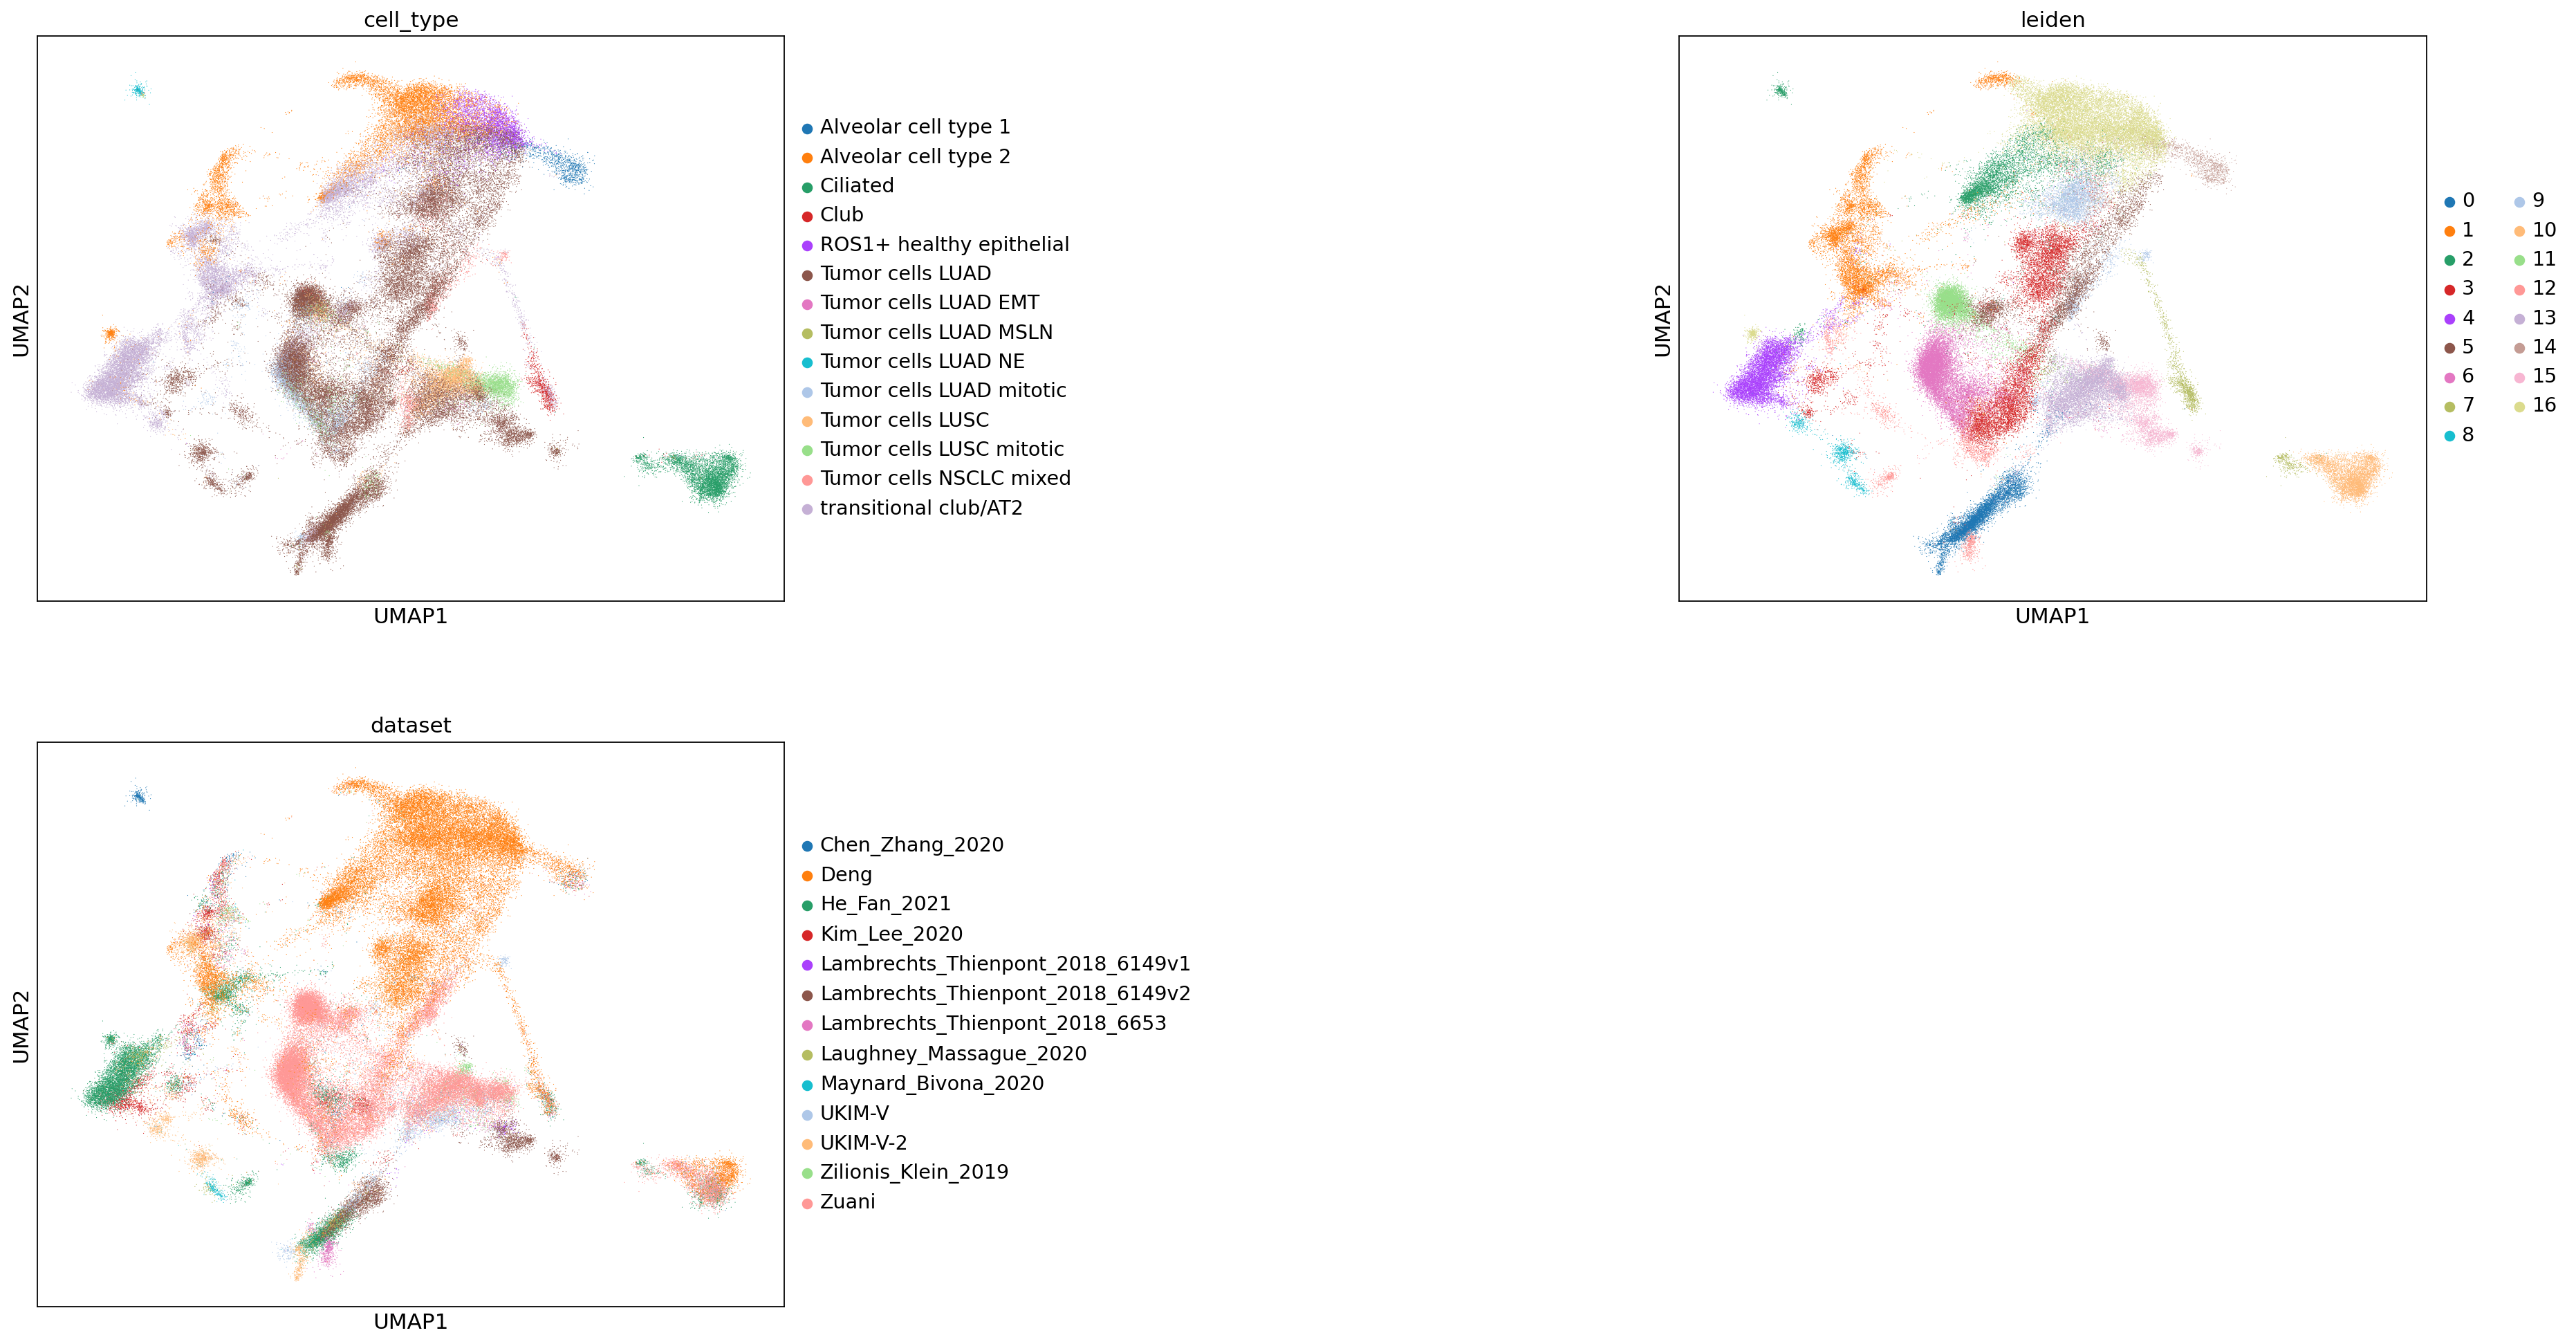

In [205]:
sc.set_figure_params(figsize=[7,7])
sc.pl.umap(ref_latent_tumor, ncols=2,color=['cell_type', 'leiden', 'dataset'], wspace=1, frameon=True)

Highlight some cluster for inspection

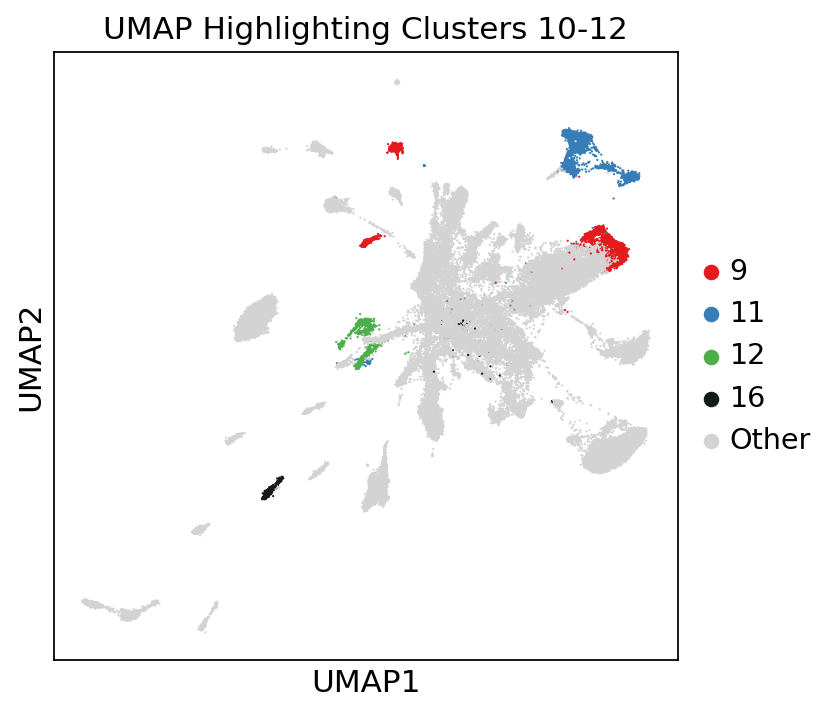

In [93]:
import matplotlib.pyplot as plt

clusters_to_highlight = ['16', '9', '11', '12'] 

# First, ensure that 'leiden_res0_25' is of string type for consistent comparison
ref_latent_tumor.obs['leiden_str'] = ref_latent_tumor.obs['leiden'].astype(str)

# Create the 'leiden_highlight' column
ref_latent_tumor.obs['leiden_highlight'] = ref_latent_tumor.obs['leiden_str'].apply(
    lambda x: x if x in clusters_to_highlight else 'Other'
)

custom_palette = {
    '16': '#141a1c',    # Black
    '9': '#e41a1c',    # Red
    '11': '#377eb8',    # Blue
    '12': '#4daf4a',    # Green
    'Other': '#d3d3d3'   # Light Grey
}
# Step 4: Plot the UMAP with Custom Annotations
sc.set_figure_params(figsize=[5,5])
sc.pl.umap(
    ref_latent_tumor,
    color='leiden_highlight',
    palette=custom_palette,
    size=4,                      # Increased size for better visibility
    # legend_loc='right margin',    # Position the legend on the right
    # legend_fontsize=12,
    title='UMAP Highlighting Clusters 10-12'
)

### Contingency

In [206]:
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `adata` is your AnnData object and the two obs columns are 'col1' and 'col2'
# Replace 'col1' and 'col2' with your actual column names
col1 = 'leiden'
col2 = 'cell_type'

# Extract the two columns from the obs dataframe
labels1 = ref_latent_tumor.obs[col1]
labels2 = ref_latent_tumor.obs[col2]

contingency_table = pd.crosstab(labels1, labels2)
# Normalize the table to get percentages
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

contingency_table_T = contingency_table.T
contingency_table_percentage_T = contingency_table_T.div(contingency_table_T.sum(axis=1), axis=0) * 100


Text(0.5, 1.0, '% of Cells in Annotated Cell Type')

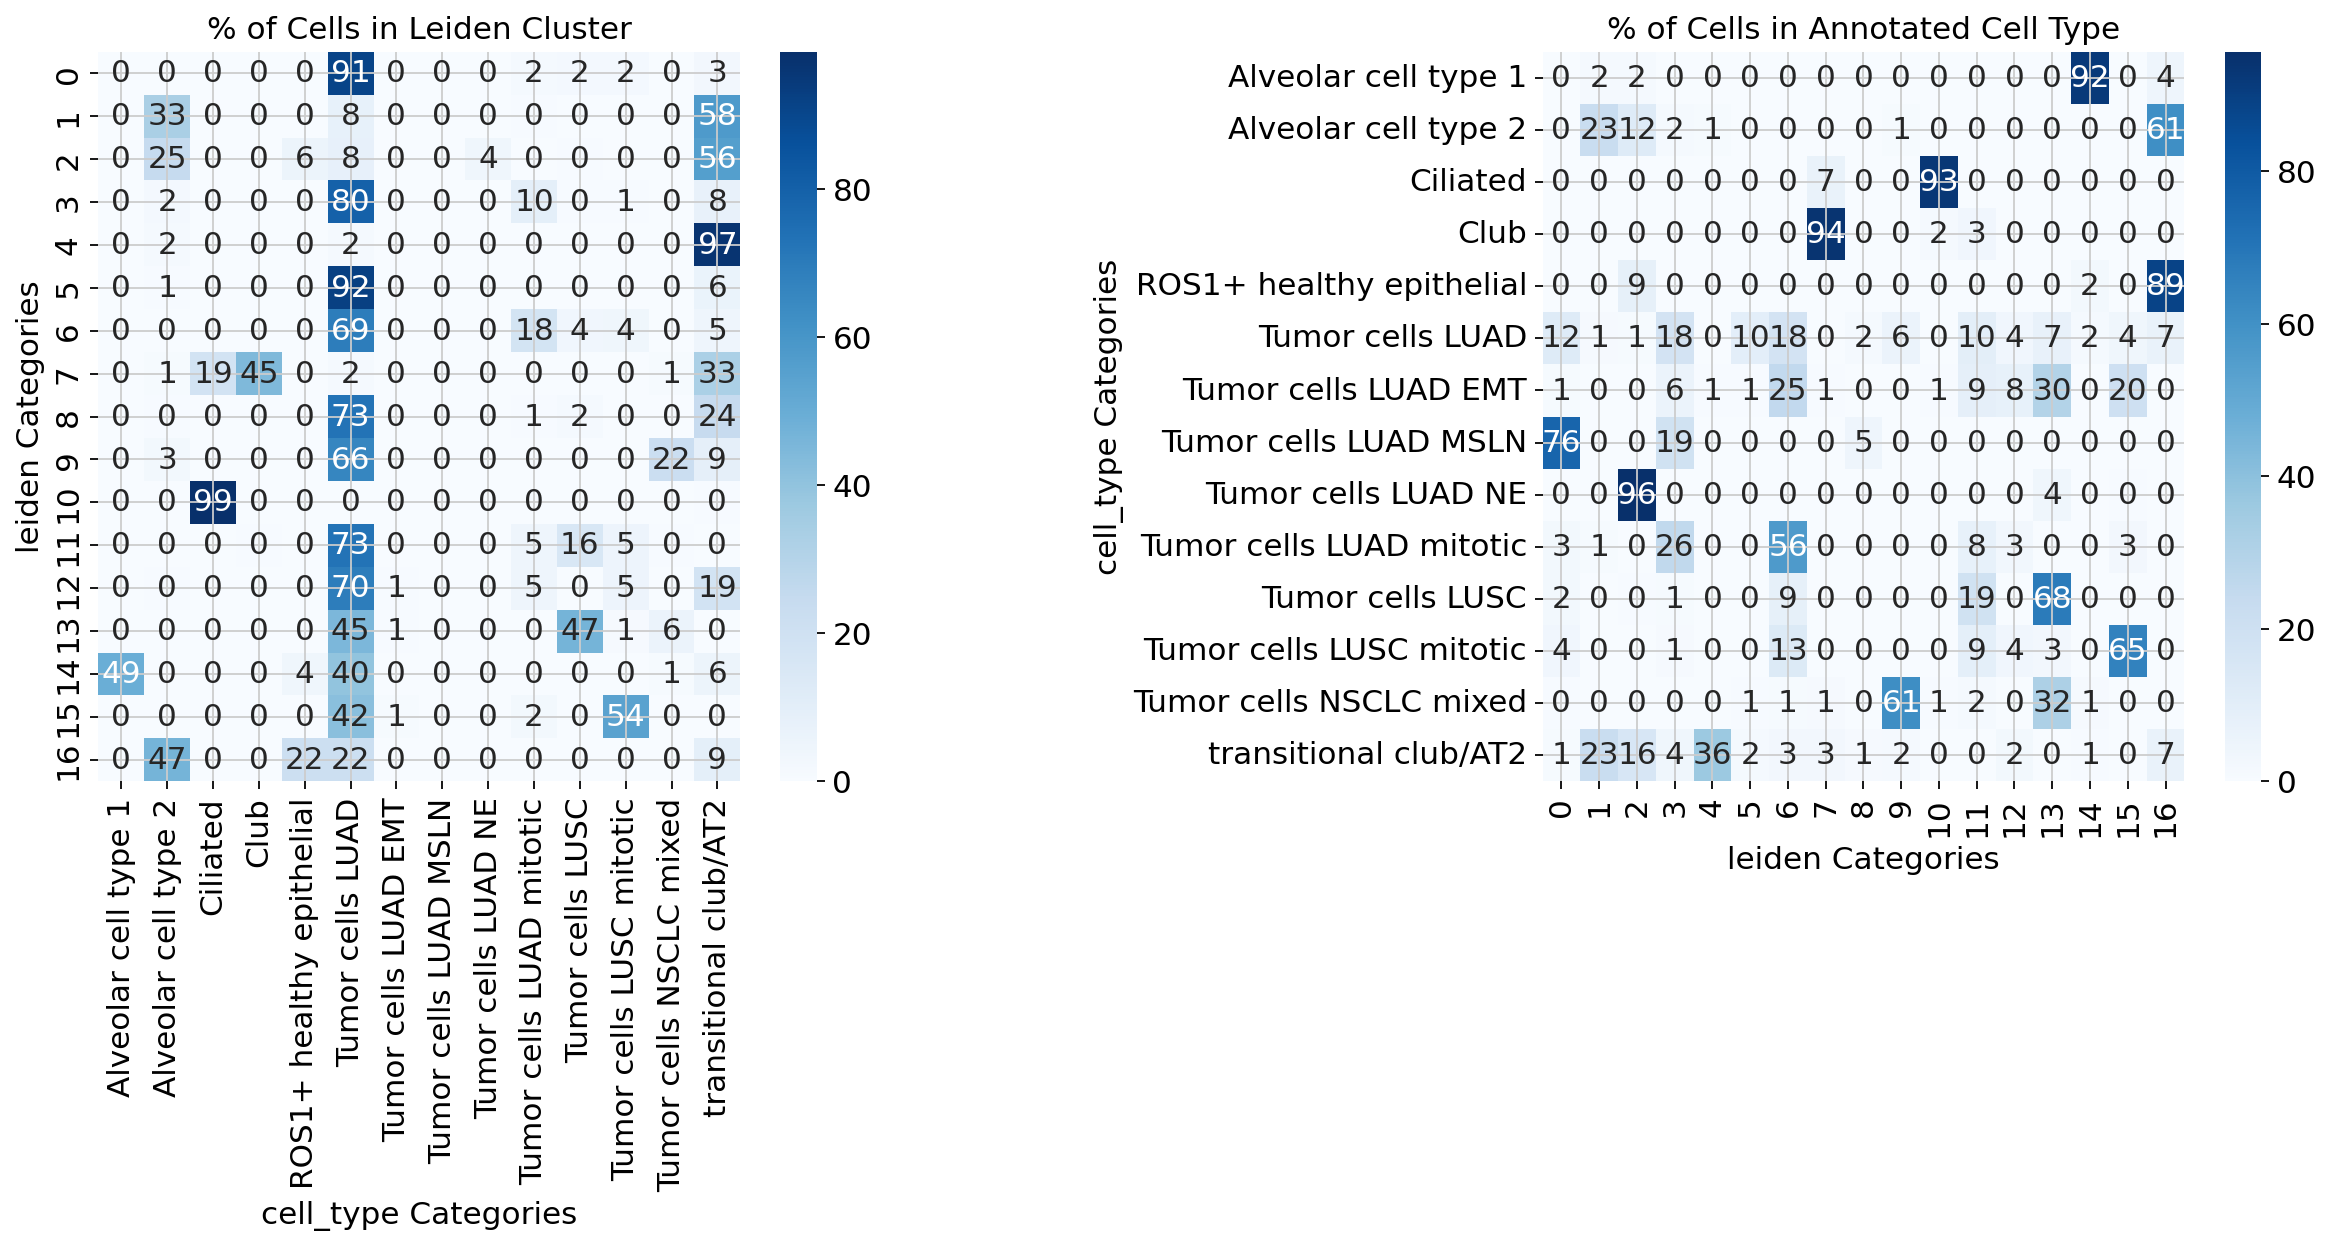

In [207]:
# Visualize the matrix using seaborn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(wspace=0.8)

sns.heatmap(contingency_table_percentage, annot=True, fmt='.0f', cmap='Blues', ax=ax1)
ax1.set_xlabel(f'{col2} Categories')
ax1.set_ylabel(f'{col1} Categories')
ax1.set_title('% of Cells in Leiden Cluster')

sns.heatmap(contingency_table_percentage_T, annot=True, fmt='.0f', cmap='Blues', ax=ax2)
ax2.set_xlabel(f'{col1} Categories')
ax2.set_ylabel(f'{col2} Categories')
ax2.set_title('% of Cells in Annotated Cell Type')

### Map Leiden number to cell type

In [307]:
leiden_mapping = {
    0: 'Tumor LUAD_mainly', 
    1: 'Club_AT2_even_1', # Has a ver low percentage of LUAD but the confusion is tractable
    2: 'Club_AT2_even_2',
    3: 'Tumor LUAD_mainly_AT2_mitotic',
    4: 'Club_AT2_high',
    5: 'Tumor LUAD_mainly_AT2_low',
    6: 'Tumor LUAD_mitotic', # has not that much just NSCLC
    7: 'Club_Ciliated', # Club are basal cells so maybe this makes some sense
    8: 'Tumor LUAD_AT2_high',
    9: 'Tumor LAUD_LUSC_AT2',
    10:'Ciliated',
    11:'Tumor LUAD_LUSC_mitotic',
    12:'Tumor LUAD_AT2_mitotic',
    13:'Tumor LUAD_LUSC',
    14:'AT1',
    15:'Tumor LUAD_LUSC_mitotic_even',
    16:'AT2_ROS1+',
}

with open(f'{surgeries}/Subcluster/mapping_{time}_leiden.json', 'w') as fp:
        json.dump(leiden_mapping, fp)

## Tumor late

In [308]:
import json
time = 'late'
ref_latent_tumor = ref_latent_tumor_late if time == 'late' else ref_latent_tumor_early
ref_latent_tumor

AnnData object with n_obs × n_vars = 80948 × 10
    obs: 'cell_type', 'batch', 'stage', 'dataset', 'dataset2', 'cell_type_adjusted', 'leiden', 'leiden_str', 'leiden_highlight', 'leiden_adjusted'
    uns: 'umap', 'cell_type_colors', 'leiden_colors', 'dataset_colors', 'leiden_highlight_colors'
    obsm: 'X_umap'

### Calculate UMAP (local)

In [ ]:
sc.pp.neighbors(ref_latent_tumor,
                # n_pcs=30
               )
sc.tl.umap(ref_latent_tumor)

In [ ]:
sc.tl.leiden(ref_latent_tumor, key_added="leiden", resolution=0.25)

/tmp/ipykernel_13315/2383314857.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(ref_latent_tumor, key_added="leiden_res0_25", resolution=0.25)


### Calculate UMAP (faiss)

The steps here can be done with the `faiss_cluster.py` script for much faster NN and clustering accelerated by GPU.

Run `modal run faiss_cluster.py` in this folder to get all the neccesary files.

In [303]:
leiden_nums = pd.read_csv(f'{surgeries}/Subcluster/atlas_{time}_leiden.csv', index_col=0)
umap_embed = pd.read_csv(f'{surgeries}/Subcluster/atlas_{time}_umap.csv', index_col=0)
uparams  = json.load(open(f'{surgeries}/Subcluster/atlas_{time}_uparams.json'))

ref_latent_tumor.obs['leiden'] = leiden_nums.loc[ref_latent_tumor.obs.index, 'leiden']
ref_latent_tumor.obs['leiden'] = ref_latent_tumor.obs['leiden'].astype('category')
umap_embed.index = ref_latent_tumor.obs.index
ref_latent_tumor.obsm['X_umap'] = umap_embed.to_numpy()
ref_latent_tumor.uns['umap'] = uparams
uparams

{'n_neighbors': 30,
 'n_components': 2,
 'min_dist': 0.03,
 'spread': 0.6,
 'random_state': 42,
 'method': 'cuml-umap',
 'leiden_resol': 0.5}

### Paint UMAP

Wu_Zhou is very seprated i think the batch effect correction may not have worked for it

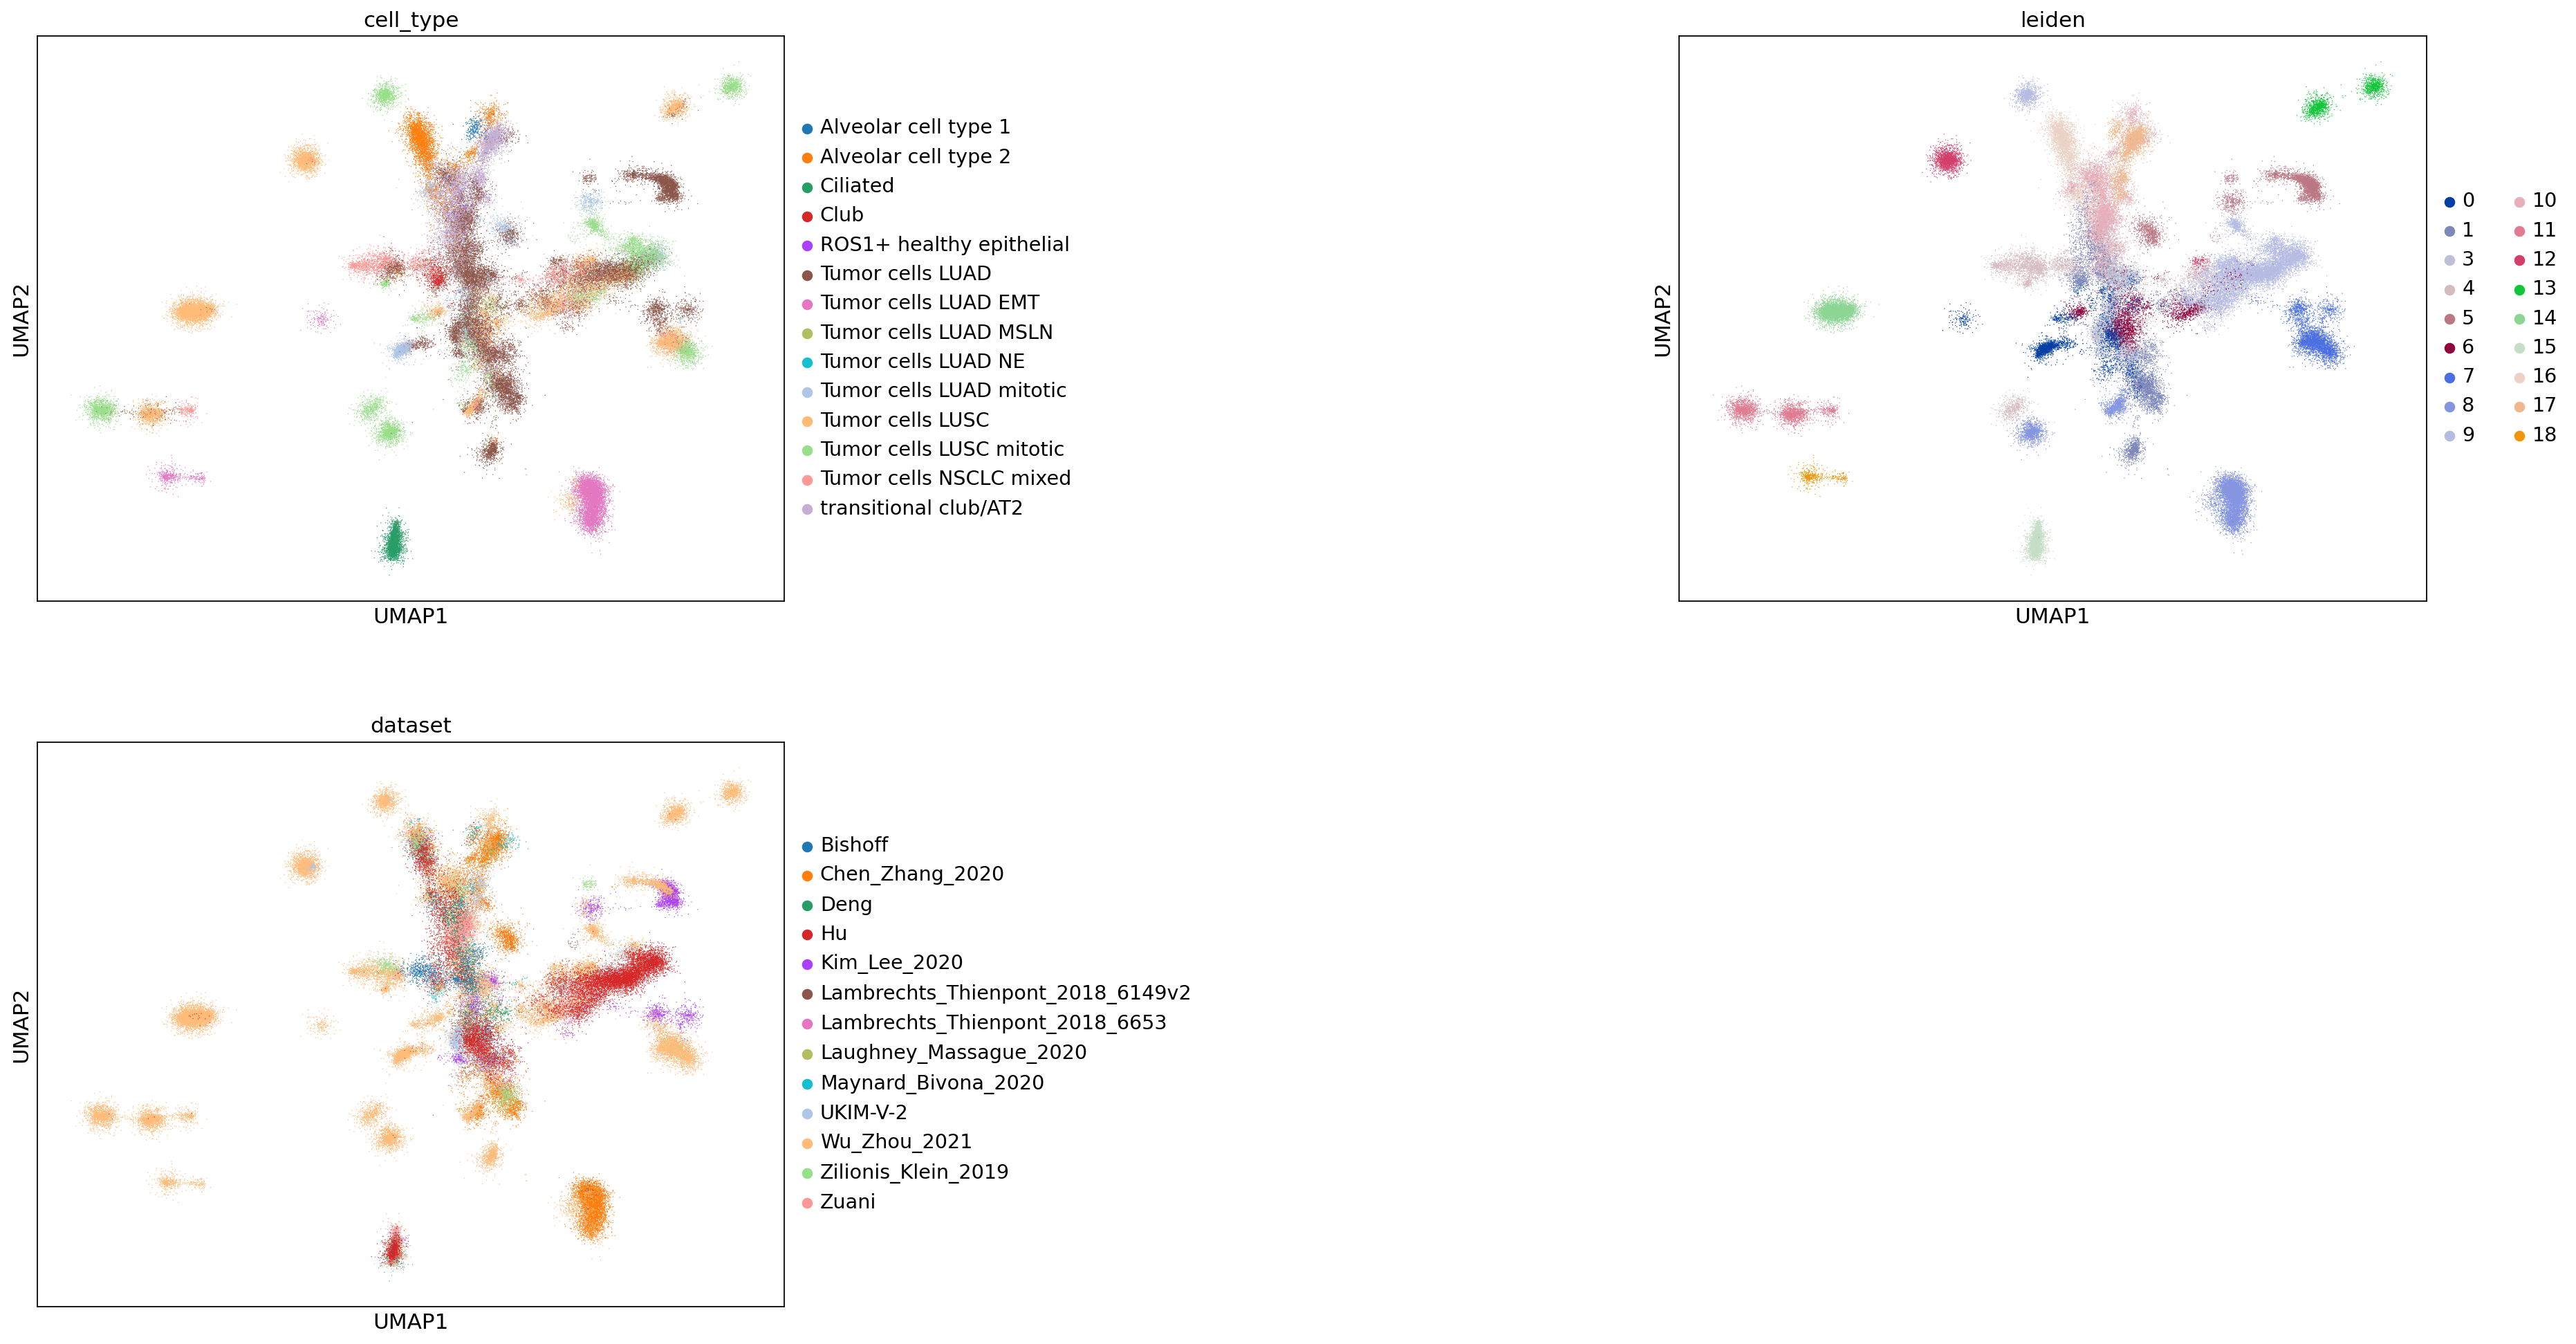

In [255]:
sc.set_figure_params(figsize=[7,7])
sc.pl.umap(ref_latent_tumor, ncols=2,color=['cell_type', 'leiden', 'dataset'], wspace=1,)

Highlight some cluster for inspection

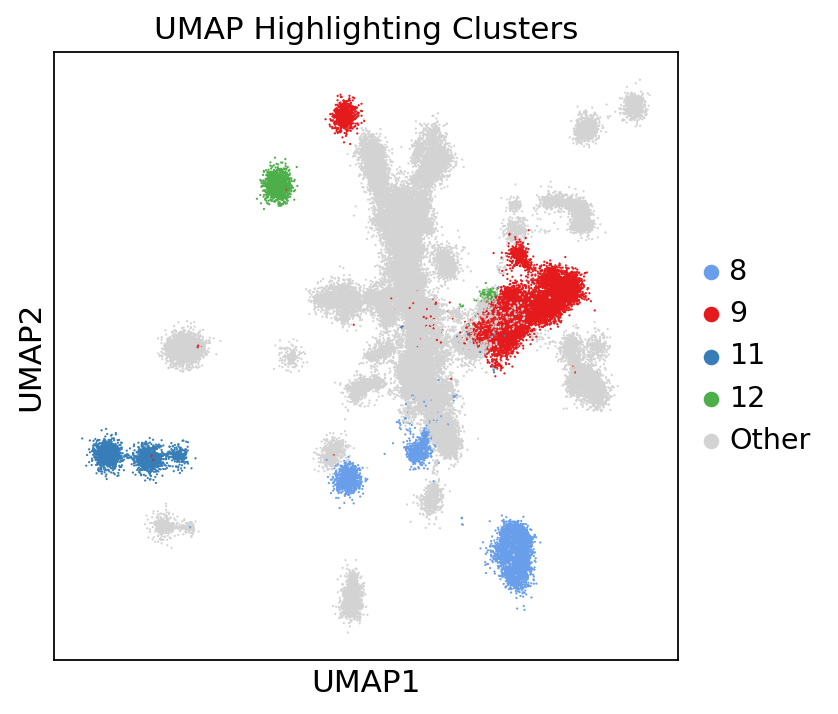

In [262]:
import matplotlib.pyplot as plt

clusters_to_highlight = ['8', '9', '11', '12'] 

# First, ensure that 'leiden_res0_25' is of string type for consistent comparison
ref_latent_tumor.obs['leiden_str'] = ref_latent_tumor.obs['leiden'].astype(str)

# Create the 'leiden_highlight' column
ref_latent_tumor.obs['leiden_highlight'] = ref_latent_tumor.obs['leiden_str'].apply(
    lambda x: x if x in clusters_to_highlight else 'Other'
)

custom_palette = {
    '8': '#699fea',    # Black
    '9': '#e41a1c',    # Red
    '11': '#377eb8',    # Blue
    '12': '#4daf4a',    # Green
    'Other': '#d3d3d3'   # Light Grey
}
# Step 4: Plot the UMAP with Custom Annotations
sc.set_figure_params(figsize=[5,5])
sc.pl.umap(
    ref_latent_tumor,
    color='leiden_highlight',
    palette=custom_palette,
    size=4,                      # Increased size for better visibility
    # legend_loc='right margin',    # Position the legend on the right
    # legend_fontsize=12,
    title='UMAP Highlighting Clusters'
)

### Contingency

In [242]:
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `adata` is your AnnData object and the two obs columns are 'col1' and 'col2'
# Replace 'col1' and 'col2' with your actual column names
col1 = 'leiden'
col2 = 'cell_type'

# Extract the two columns from the obs dataframe
labels1 = ref_latent_tumor.obs[col1]
labels2 = ref_latent_tumor.obs[col2]

contingency_table = pd.crosstab(labels1, labels2)
# Normalize the table to get percentages
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

contingency_table_T = contingency_table.T
contingency_table_percentage_T = contingency_table_T.div(contingency_table_T.sum(axis=1), axis=0) * 100


Text(0.5, 1.0, '% of Cells in Annotated Cell Type')

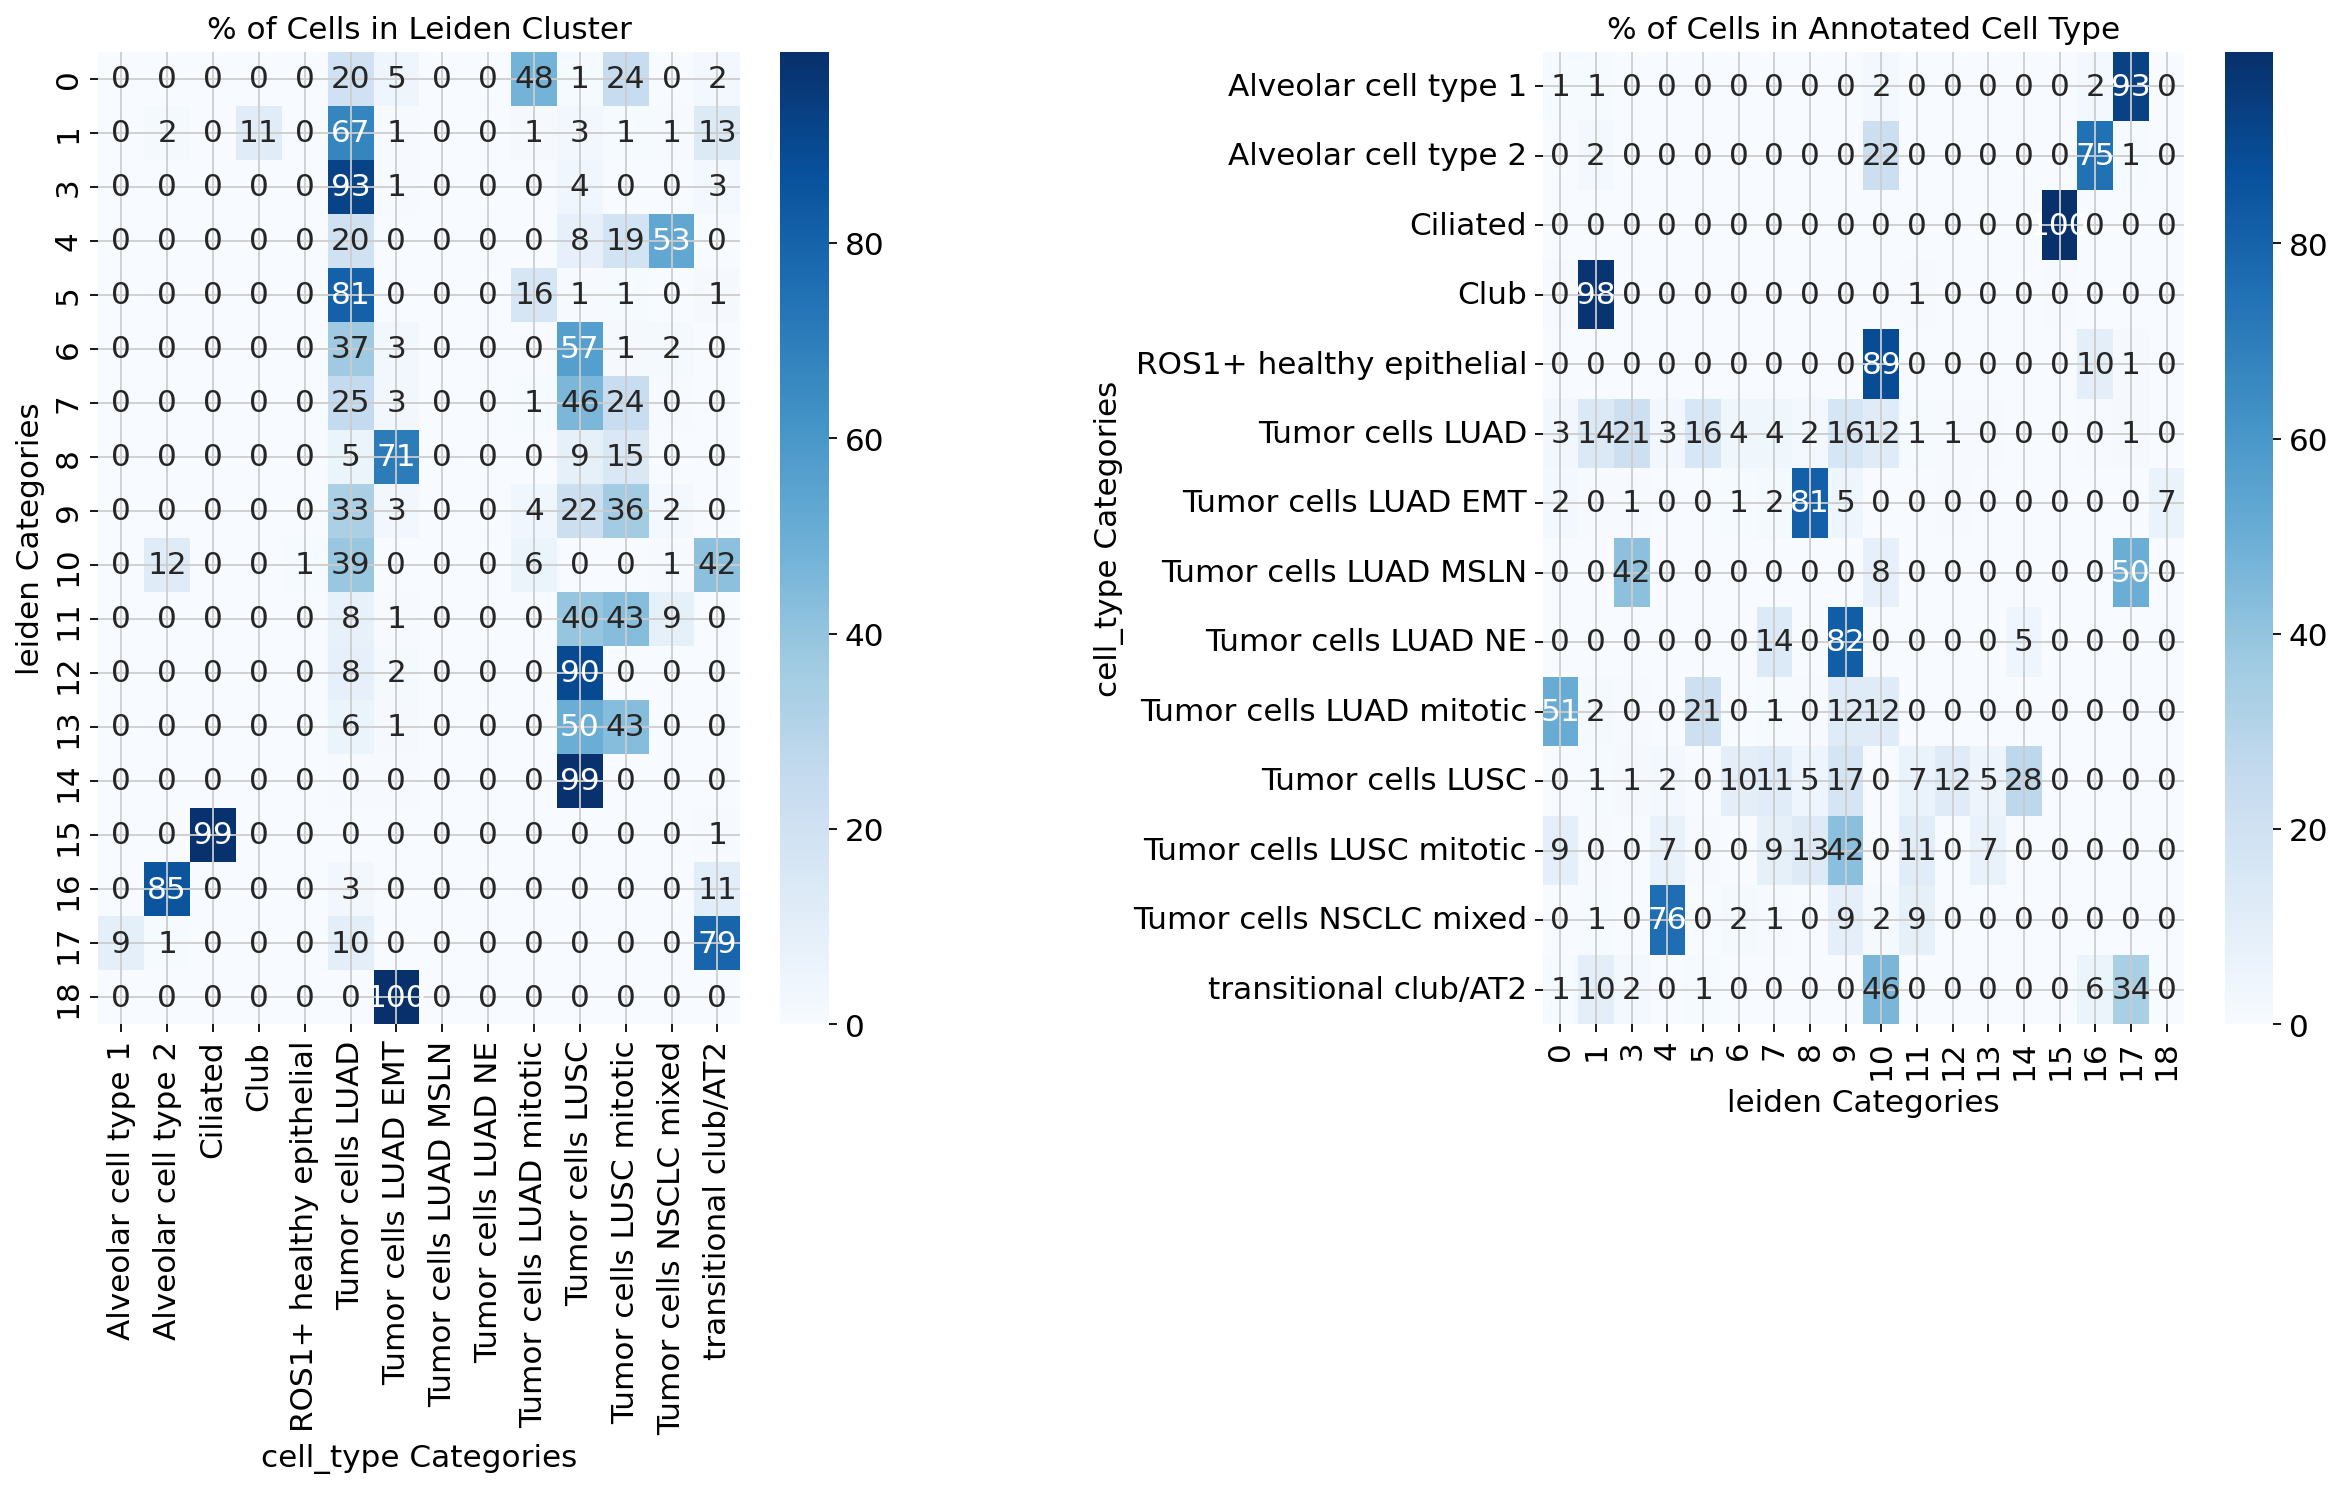

In [253]:
# Visualize the matrix using seaborn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
plt.subplots_adjust(wspace=0.8)

sns.heatmap(contingency_table_percentage, annot=True, fmt='.0f', cmap='Blues', ax=ax1)
ax1.set_xlabel(f'{col2} Categories')
ax1.set_ylabel(f'{col1} Categories')
ax1.set_title('% of Cells in Leiden Cluster')

sns.heatmap(contingency_table_percentage_T, annot=True, fmt='.0f', cmap='Blues', ax=ax2)
ax2.set_xlabel(f'{col1} Categories')
ax2.set_ylabel(f'{col2} Categories')
ax2.set_title('% of Cells in Annotated Cell Type')

### Map Leiden number to cell type

In [309]:
leiden_mapping = {
    0: 'Tumor LUSC_LUAD_mitotic',
    1: 'Tumor LUAD_AT2_Club',
    # 2: 'Tumor LUAD_LUSC_mitotic',
    3: 'Tumor LUAD',
    4: 'Tumor NSCLC_mixed',
    5: 'Tumor LUAD_mitotic',
    6: 'Tumor LUSC_LUAD', # has not that much just NSCLC
    7: 'Tumor LUSC_mitotic_LUAD', # These are mostly isolated but we would like ti to be more mixed to have more interactions
    8: 'Tumor EMT_mitotic',
    9: 'Tumor LUAD_mitotic_LUSC',
    10:'Tumor AT2_LUAD',
    11:'Tumor LUSC_mitotic',
    12:'Tumor LUSC',
    13:'Tumor LUSC_mitotic2',
    14:'Tumor LUSC2', # This is not that good and like with ROS1+.... our clustering is competing agianst our neural network and the NN should win
    15:'Ciliated',
    16:'AT2',
    17:'Club/AT2',
    18:'Tumor LUSC_mitotic',
}

with open(f'{surgeries}/Subcluster/mapping_{time}_leiden.json', 'w') as fp:
    json.dump(leiden_mapping, fp)

## Export new annots for each dataset

In [297]:
ref_latent_tumor.obs['leiden_adjusted'] = ref_latent_tumor.obs['leiden'].apply(lambda x: leiden_mapping[int(x)])

# trampa para no tener que hacer el mapping
ref_latent_tumor.obs['leiden_adjusted']

AAACCCAAGATTAGAC-1_0-1    Tumor LUAD_AT2_Club
AAACCCAGTACGATTC-1_0-1    Tumor LUAD_AT2_Club
AAACGAAAGGGCTAAC-1_0-1    Tumor LUAD_AT2_Club
AAACGAATCCGATGCG-1_0-1    Tumor LUAD_AT2_Club
AAACGCTAGACTGTTC-1_0-1    Tumor LUAD_AT2_Club
                                 ...         
BD_immune09_311353_Hu         Tumor LUSC_LUAD
BD_immune10_52807_Hu       Tumor LUSC_mitotic
BD_immune13_644587_Hu     Tumor LUAD_AT2_Club
BD_immune12_753660_Hu      Tumor LUSC_mitotic
BD_immune13_111313_Hu      Tumor LUSC_mitotic
Name: leiden_adjusted, Length: 80948, dtype: object

In [298]:
datasets = ['Hu', 'Bishoff','Zuani', 'Deng']
ref_latent.obs['dataset'] = ref_latent.obs['dataset'].astype('str')
ref_latent.obs['dataset2'] = ref_latent.obs['dataset']

ref_latent.obs.loc[np.logical_not(ref_latent.obs['dataset'].isin(datasets)),'dataset2'] = 'Atlas'
ref_latent.obs

cell_type            batch stage  \
AAACCCAAGAGCCATG-1_0-1  T cell CD8 effector memory  Chen_Zhang_2020   III   
AAACCCAAGATTAGAC-1_0-1            Tumor cells LUAD  Chen_Zhang_2020   III   
AAACCCAAGGTCGCCT-1_0-1                      B cell  Chen_Zhang_2020   III   
AAACCCAAGTCATTGC-1_0-1                      B cell  Chen_Zhang_2020   III   
AAACCCACACGGATCC-1_0-1                 Plasma cell  Chen_Zhang_2020   III   
...                                            ...              ...   ...   
BD_immune13_111313_Hu     Tumor cells LUSC mitotic   BD_immune13_Hu   III   
BD_immune13_791956_Hu                   Macrophage   BD_immune13_Hu   III   
BD_immune14_462072_Hu              B cell dividing   BD_immune14_Hu   III   
BD_immune14_124095_Hu              B cell dividing   BD_immune14_Hu   III   
BD_immune15_20126_Hu              NK cell dividing   BD_immune15_Hu   III   

                                dataset dataset2          cell_type_adjusted  
AAACCCAAGAGCCATG-1_0-1  Chen_Zhang_2020    Atlas  T cell CD8 effector memory  
AAACCCAAGATTAGAC-1_0-1  Chen_Zhang_2020    Atlas            Tumor cells LUAD  
AAACCCAAGGTCGCCT-1_0-1  Chen_Zhang_2020    Atlas                      B cell  
AAACCCAAGTCATTGC-1_0-1  Chen_Zhang_2020    Atlas                      B cell  
AAACCCACACGGATCC-1_0-1  Chen_Zhang_2020    Atlas                 Plasma cell  
...                                 ...      ...                         ...  
BD_immune13_111313_Hu                Hu       Hu    Tumor cells LUSC mitotic  
BD_immune13_791956_Hu                Hu       Hu                  Macrophage  
BD_immune14_462072_Hu                Hu       Hu             B cell dividing  
BD_immune14_124095_Hu                Hu       Hu             B cell dividing  
BD_immune15_20126_Hu                 Hu       Hu            NK cell dividing  

[1149161 rows x 6 columns]

In [299]:
time

'late'

In [300]:
ref_latent.obs['cell_type'].unique()

['T cell CD8 effector memory', 'Tumor cells LUAD', 'B cell', 'Plasma cell', 'T cell regulatory', ..., 'Mesothelial', 'Endothelial cell lymphatic', 'Tumor cells NSCLC mixed', 'Tumor cells LUAD NE', 'Tumor cells LUAD MSLN']
Length: 51
Categories (51, object): ['Alveolar cell type 1', 'Alveolar cell type 2', 'B cell', 'B cell dividing', ..., 'myeloid dividing', 'pDC', 'stromal dividing', 'transitional club/AT2']

In [302]:
import numpy as np
import pandas as pd

# Step 1: Create a new column 'cell_type_adjusted' in ref_latent.obs
ref_latent.obs['cell_type_adjusted'] = ref_latent.obs['cell_type'].astype(str)

# Step 2: Identify tumor cells in ref_latent_tumor. We make the decision to 
# `steal` the epithelial cells from their just assignment. But we do not redistribute the epithelial cells according tou our cluster because, 
# Our scvi neural network trumps the clusters.

# tumor_cells = ref_latent_tumor.obs.index[
#     ref_latent_tumor.obs['leiden_adjusted'].str.contains('Tumor')
# ]

tumor_cells = ref_latent_tumor.obs.index

# TODO ONLY TEMPORARY TO DELINEATE TUMOR CELLS
# ref_latent_tumor.obs[ 'leiden_adjusted'] = 'Tumor_' + ref_latent_tumor.obs[ 'leiden_adjusted'].astype(str)

# Step 3: Overwrite predictions for tumor cells with Leiden clusters
ref_latent.obs.loc[tumor_cells, 'cell_type_adjusted'] = (
    ref_latent_tumor.obs.loc[tumor_cells, 'leiden_adjusted'].astype(str)
)

# Check that the cell types have been updated correctly
assert set(ref_latent.obs.loc[tumor_cells, 'cell_type_adjusted'].astype(str).unique()) == set(ref_latent_tumor.obs['leiden_adjusted'].astype(str).unique())

# Step 4: Export predictions for each dataset
datasets = ref_latent.obs['dataset2'].unique()

for ds in datasets:
    # Subset cells belonging to the current dataset
    cells_in_ds = ref_latent.obs[ref_latent.obs['dataset2'] == ds]
    
    # Create a DataFrame with cell IDs and adjusted cell types
    export_df = cells_in_ds[['cell_type_adjusted','cell_type','batch']].copy()
    export_df.reset_index(inplace=True)
    if ds in ['Hu', 'Bishoff', 'Deng', 'Zuani']:
        export_df['index'] = export_df['index'].str.split('_').str[:-1].str.join('_')
    # export_df.rename(columns={'index': 'cell_id'}, inplace=True)
    
    # Define the filename (adjust the path as needed)
    filename = f"{surgeries}/{ds}_predicted_leiden_{time}.csv"
    
    # Export to CSV
    export_df.to_csv(filename, index=False)
    
    print(f"Exported predictions for dataset '{ds}' to '{filename}'")


Exported predictions for dataset 'Atlas' to '/root/datos/maestria/netopaas/luca_explore/surgeries//Atlas_predicted_leiden_late.csv'
Exported predictions for dataset 'Zuani' to '/root/datos/maestria/netopaas/luca_explore/surgeries//Zuani_predicted_leiden_late.csv'
Exported predictions for dataset 'Bishoff' to '/root/datos/maestria/netopaas/luca_explore/surgeries//Bishoff_predicted_leiden_late.csv'
Exported predictions for dataset 'Deng' to '/root/datos/maestria/netopaas/luca_explore/surgeries//Deng_predicted_leiden_late.csv'
Exported predictions for dataset 'Hu' to '/root/datos/maestria/netopaas/luca_explore/surgeries//Hu_predicted_leiden_late.csv'


## Zuani only healthy (DEPRECATED)

KeyError: 'Could not find key leiden_res0_25 in .var_names or .obs.columns.'

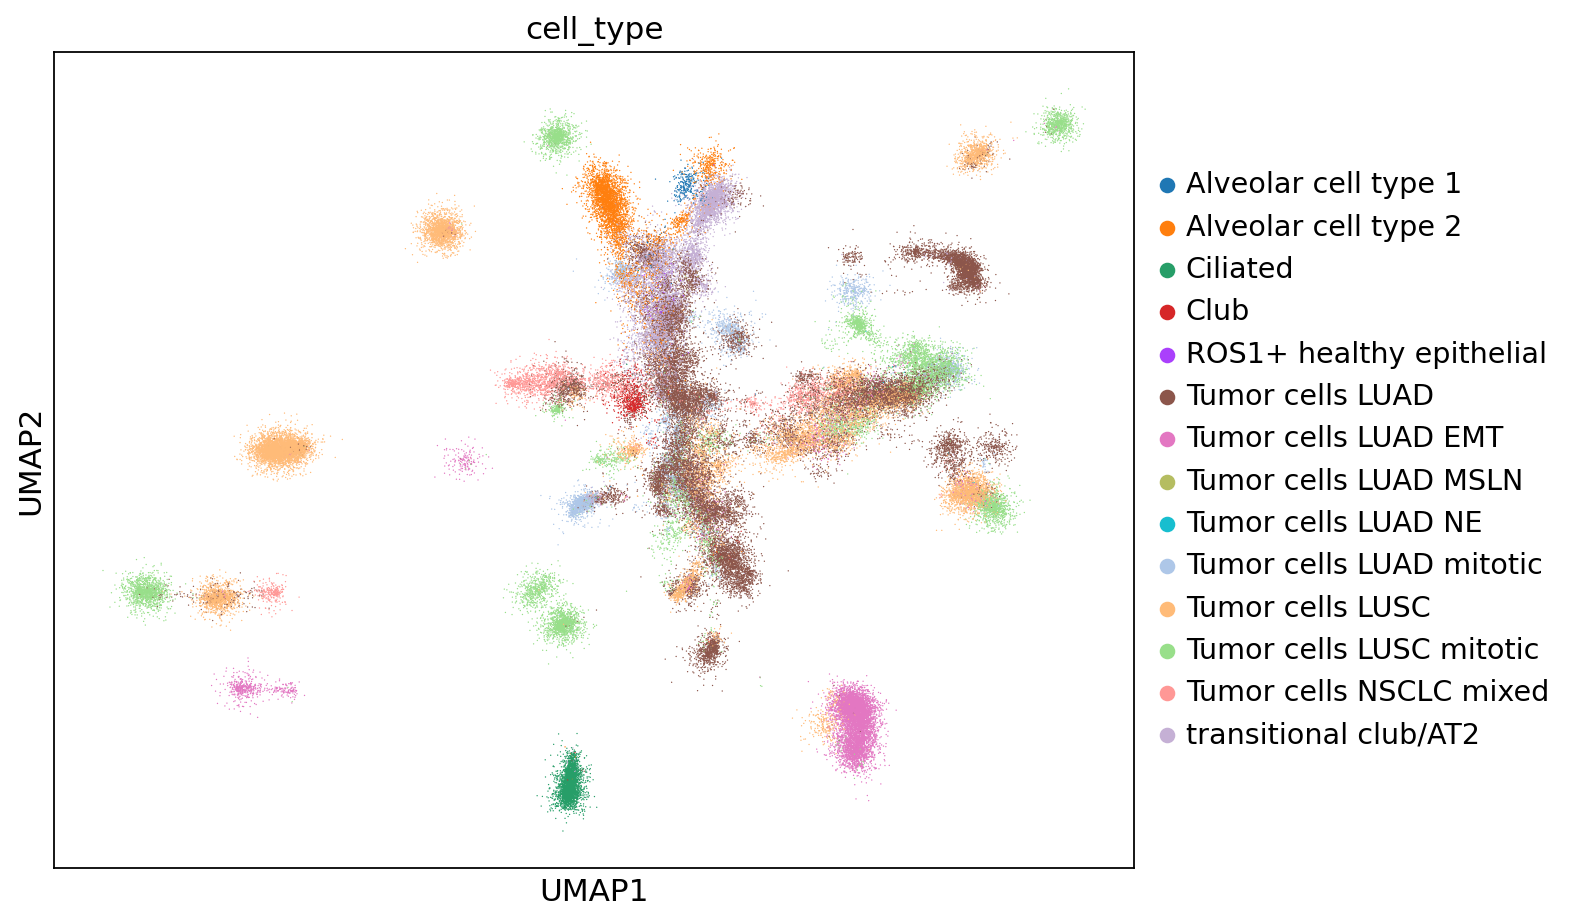

In [273]:
sc.set_figure_params(figsize=[7,7])
sc.pl.umap(ref_latent_tumor, ncols=2,color=['cell_type', 'leiden_res0_25', 'dataset'], wspace=1)

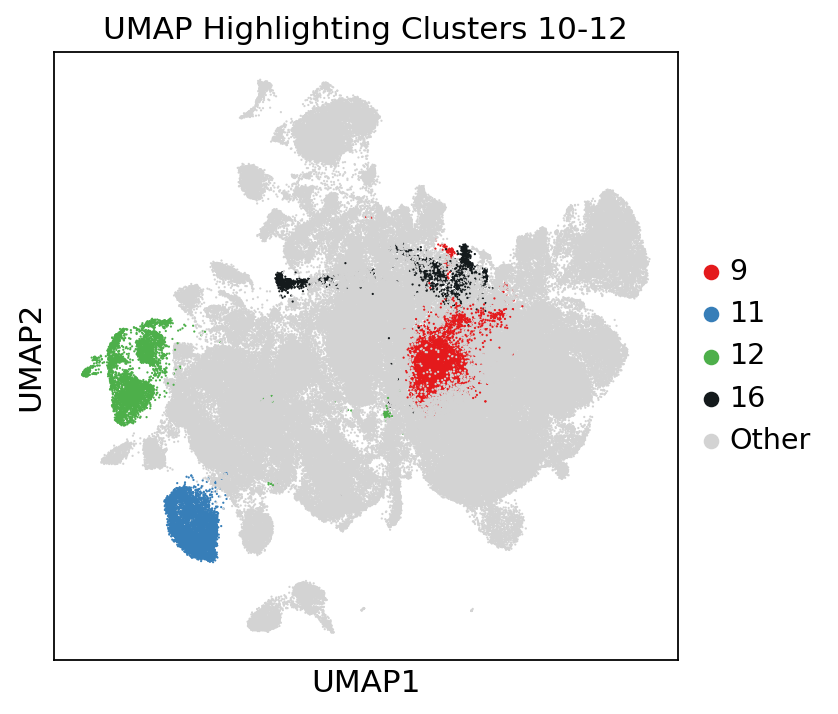

In [ ]:
import matplotlib.pyplot as plt

clusters_to_highlight = ['16', '9', '11', '12'] 

# First, ensure that 'leiden_res0_25' is of string type for consistent comparison
ref_latent_tumor.obs['leiden_res0_25_str'] = ref_latent_tumor.obs['leiden_res0_25'].astype(str)

# Create the 'leiden_highlight' column
ref_latent_tumor.obs['leiden_highlight'] = ref_latent_tumor.obs['leiden_res0_25_str'].apply(
    lambda x: x if x in clusters_to_highlight else 'Other'
)

custom_palette = {
    '16': '#141a1c',    # Black
    '9': '#e41a1c',    # Red
    '11': '#377eb8',    # Blue
    '12': '#4daf4a',    # Green
    'Other': '#d3d3d3'   # Light Grey
}
# Step 4: Plot the UMAP with Custom Annotations
sc.set_figure_params(figsize=[5,5])
sc.pl.umap(
    ref_latent_tumor,
    color='leiden_highlight',
    palette=custom_palette,
    size=4,                      # Increased size for better visibility
    # legend_loc='right margin',    # Position the legend on the right
    # legend_fontsize=12,
    title='UMAP Highlighting Clusters 10-12'
)

### Contingency

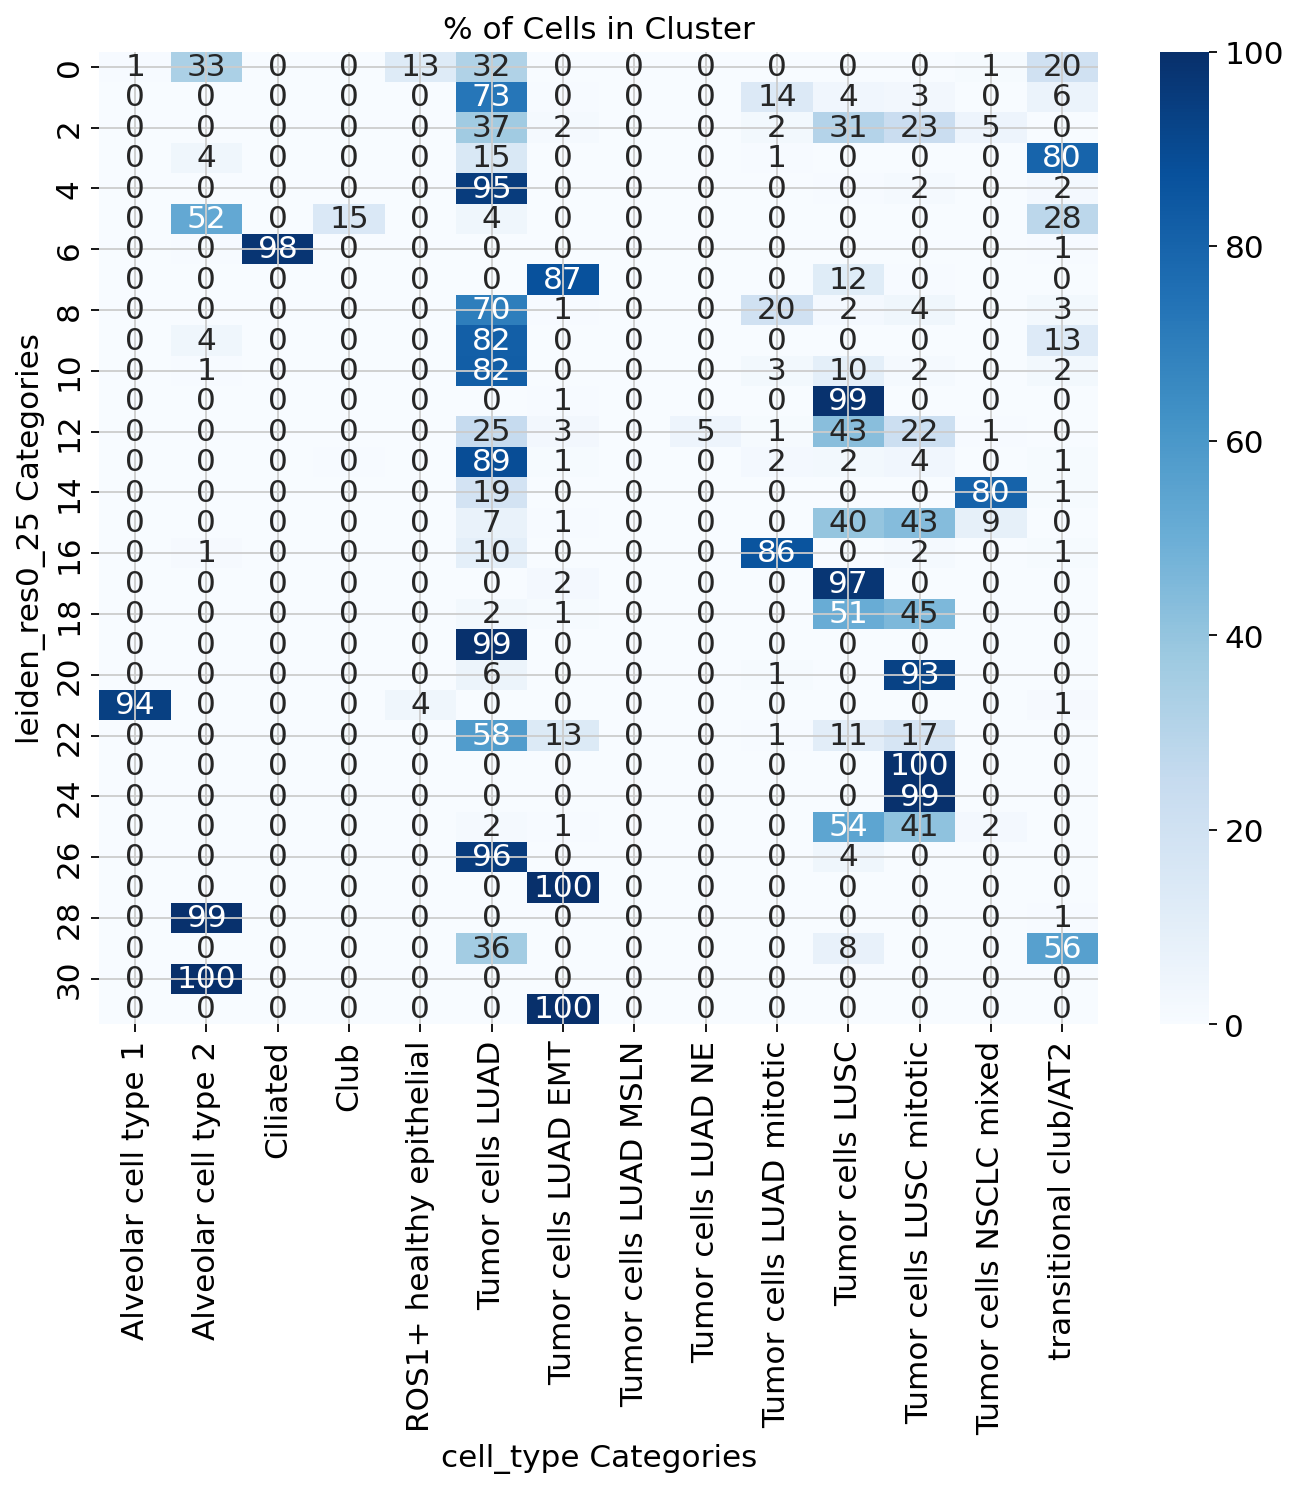

In [ ]:
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `adata` is your AnnData object and the two obs columns are 'col1' and 'col2'
# Replace 'col1' and 'col2' with your actual column names
col1 = 'leiden_res0_25'
col2 = 'cell_type'

# Extract the two columns from the obs dataframe
labels1 = ref_latent_tumor.obs[col1]
labels2 = ref_latent_tumor.obs[col2]

contingency_table = pd.crosstab(labels1, labels2)
# Normalize the table to get percentages
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Visualize the matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table_percentage, annot=True, fmt='.0f', cmap='Blues')
plt.xlabel(f'{col2} Categories')
plt.ylabel(f'{col1} Categories')
plt.title('% of Cells in Cluster')
plt.show()


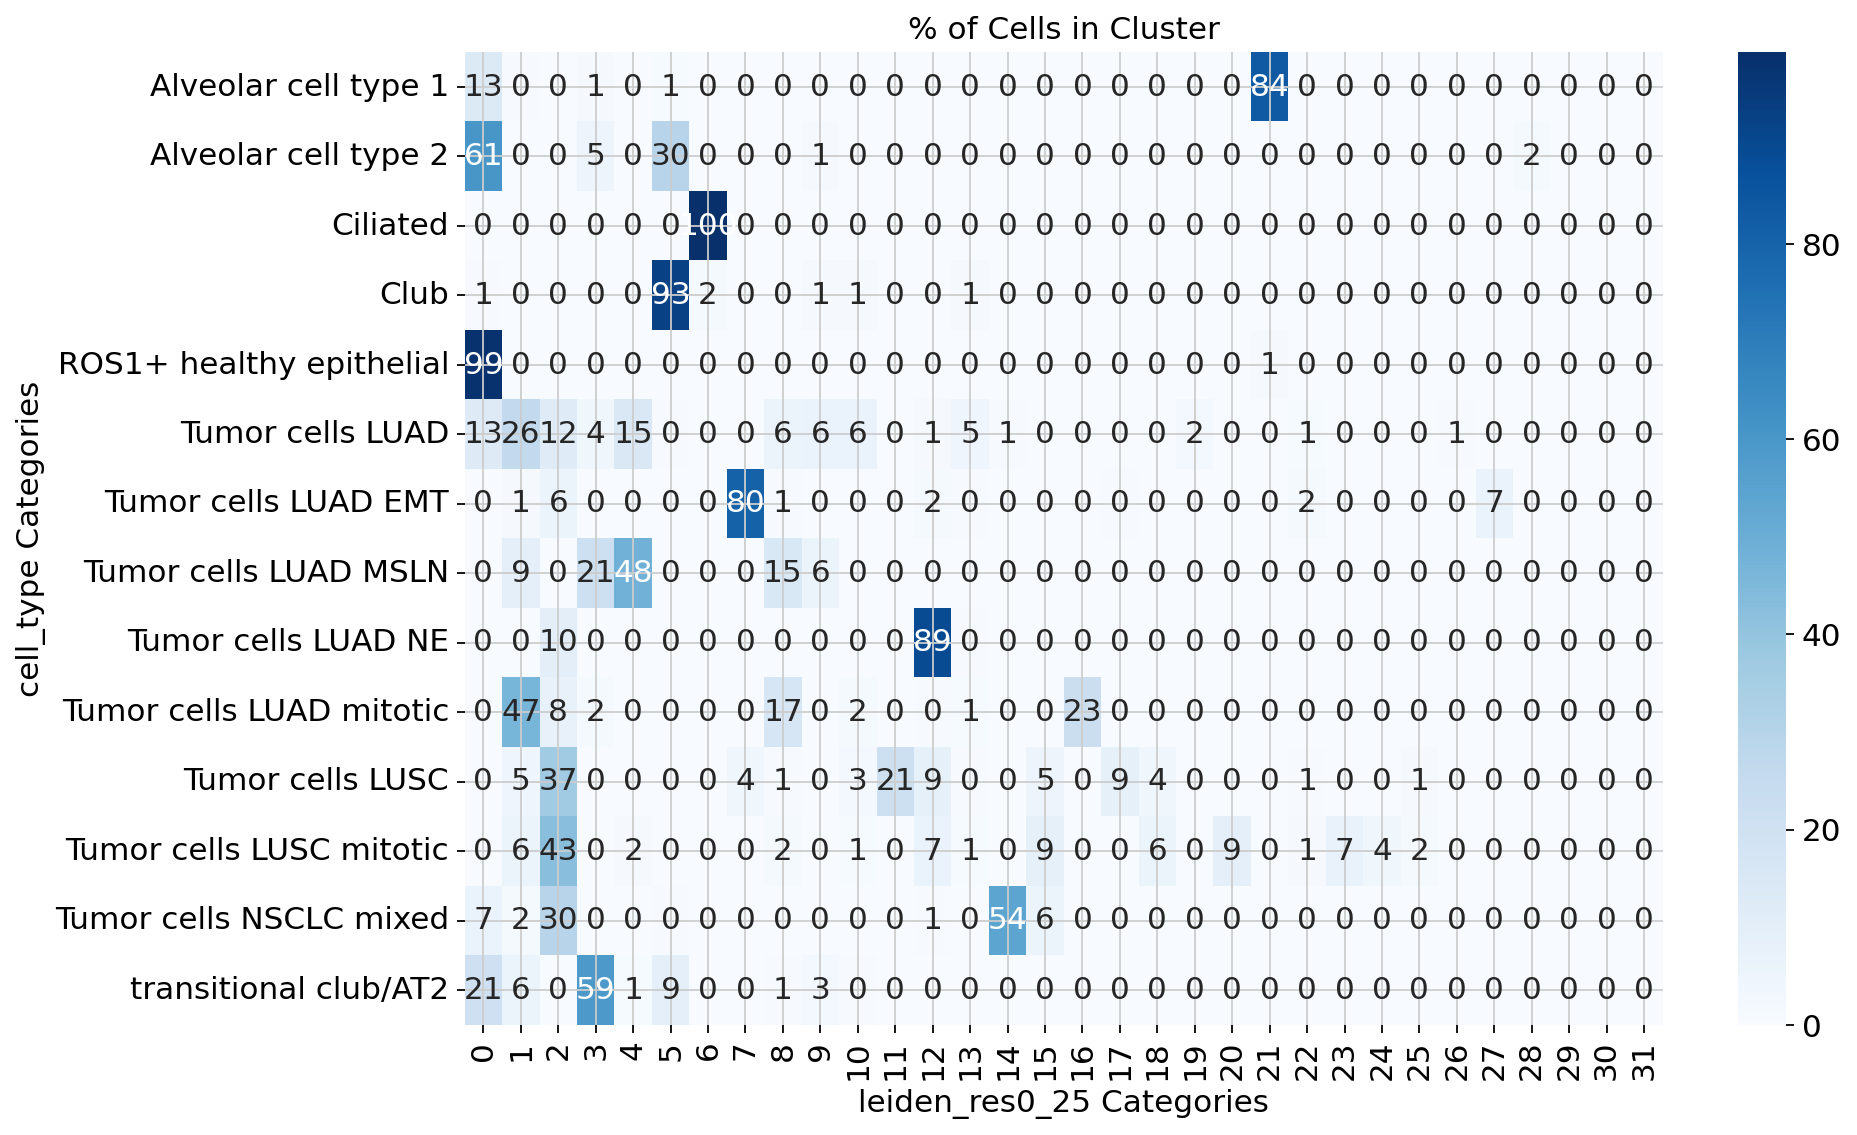

In [ ]:
contingency_table_T = contingency_table.T
contingency_table_percentage_T = contingency_table_T.div(contingency_table_T.sum(axis=1), axis=0) * 100

# Visualize the matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table_percentage_T, annot=True, fmt='.0f', cmap='Blues')
plt.xlabel(f'{col1} Categories')
plt.ylabel(f'{col2} Categories')
plt.title('% of Cells in Cluster')
plt.show()

### Map Leiden number to cell type

In [ ]:
leiden_mapping = {
    0: 'Alveolar cell type 1', # We assing this to ROS1+ healthy eptihelial cells , because they may appear tumoral because some tumors have a mutation in ROS, but they are healthy. Mybe checki g if they do have ros1+ would be nce
    1: 'Tumor LUAD_mixed',
    2: 'Tumor LUAD_LUSC_mitotic',
    3: 'transitional club/AT2',
    4: 'Tumor LUAD_transitional',
    5: 'transitional club/AT2', # We pass this to transitional because it involves both instead of just at2. We ignore the cancer because things like ros1+ and others
    6: 'Tumor LUAD_mitotic', # has not that much just NSCLC
    7: 'Tumor LUAD_EMT1', # These are mostly isolated but we would like ti to be more mixed to have more interactions
    8: 'Ciliated',
    9: 'Tumor LUSC_mainly',
    10:'Tumor LUSC_LUAD_mitotic',
    11:'Tumor LUAD_LUSC',
    12:'Tumor LUAD_Club',
    13:'Tumor LUSC_mitotic2',
    14:'Club', # This is not that good and like with ROS1+.... our clustering is competing agianst our neural network and the NN should win
    15:'Tumor mitotic_LUSC',
    16:'Tumor LUSC_mainly2',
    17:'Tumor mixed_LUAD',
    18:'Tumor LUSC_mitotic',
    19:'Tumor mitotic_mixed',
    20:'Tumor LUAD_mainly1',
    21:'Tumor LUSC_mitotic',
    22:'Alveolar cell type 2',
    23:'Tumor LUAD_EMT2',
    24:'Tumor LUAD_EMT3',
    25:'Tumor LUAD_mainly2',
    26:'Alveolar cell type 2',
    27:'Tumor LUAD_EMT3',
}

In [ ]:
ref_latent_tumor.obs['leiden_adjusted'] = ref_latent_tumor.obs['leiden_res0_25'].apply(lambda x: leiden_mapping[int(x)])
ref_latent_tumor.obs['leiden_adjusted']

1-0-0-0                            Tumor LUAD_Club
7-0-0-0                            Tumor LUAD_Club
14-0-0-0                           Tumor LUAD_Club
23-0-0-0                           Tumor LUAD_Club
25-0-0-0                           Tumor LUAD_Club
                                    ...           
BD_immune09_311353_Hu-1    Tumor LUAD_LUSC_mitotic
BD_immune10_52807_Hu-1         Tumor LUSC_mitotic2
BD_immune13_644587_Hu-1            Tumor LUAD_LUSC
BD_immune12_753660_Hu-1        Tumor LUSC_mitotic2
BD_immune13_111313_Hu-1    Tumor LUAD_LUSC_mitotic
Name: leiden_adjusted, Length: 148926, dtype: object